# Short-Term Wind Power Forecasting Using Machine Learning and Explainable AI

This notebook presents a complete time-series forecasting pipeline for short-term
wind power prediction. Baseline statistical models are compared with advanced
machine learning approaches, and explainable artificial intelligence techniques
are applied to interpret model behaviour.


# Data Cleaning and Preprocessing

Before building any forecasting models, the SCADA dataset was carefully cleaned and prepared to ensure data quality and temporal consistency. The date and time column was converted into a proper datetime format and the dataset was ordered chronologically so that past observations always precede future ones.

Initial data quality checks were performed to identify missing values and potential type inconsistencies. Rows containing missing values introduced during feature engineering were removed to avoid biased learning. These preprocessing steps ensure that the models are trained on reliable and physically meaningful data, which is essential for time series forecasting tasks.


## Environment Setup and Library Imports

This cell prepares the working environment by installing required external libraries and importing all necessary packages. It ensures that tools for data manipulation, visualization, machine learning, deep learning, and time series analysis are available before starting the main tasks. Data handling libraries are included for efficient processing, while visualization libraries support exploratory analysis. Machine learning and deep learning libraries enable model building and evaluation, and time series libraries support forecasting tasks. Overall, this cell ensures a smooth and error free execution of the notebook.


In [ ]:
!pip install catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import shap
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import logging
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from google.colab import drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.3 MB/s eta 0:00:00


# Data Loading



## Mounting Google Drive in Colab

This cell connects Google Colab to Google Drive so that files stored in Drive can be accessed directly from the notebook. Mounting the drive allows the notebook to read datasets, save trained models, and store outputs persistently. Without this step, any files created during the session would be lost when the runtime resets. This makes it easier to manage data and results across multiple sessions.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the SCADA Dataset

This cell defines the file path of the SCADA dataset stored in Google Drive and attempts to load it into a pandas DataFrame. A try and except block is used to handle possible errors during file loading. If the file is found and read successfully, a confirmation message is printed. If the file path is incorrect or the file is missing, an informative error message is displayed to guide correction. This approach helps ensure that data loading issues are identified early before further analysis is performed.


In [ ]:
# Define the path to your SCADA dataset
# IMPORTANT: Replace 'your_scada_data.csv' with the actual path to your file.

data_path = '/content/drive/MyDrive/Colab Notebooks/T1.csv' # <-- Update this line

try:
    df = pd.read_csv(data_path)
    print(f"Successfully loaded data from {data_path}")
except FileNotFoundError:
    print(f"Error: The file '{data_path}' was not found. Please ensure the path is correct.")
    exit()
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")
    exit()

Successfully loaded data from /content/drive/MyDrive/Colab Notebooks/T1.csv


## Initial Data Inspection

-   **`df.head()`**: Shows the first few rows, giving a quick overview of the data format, column values, and potential header issues.
-   **`df.columns`**: Lists all column names, which is useful for verifying expected features and checking for naming inconsistencies.
-   **`df.info()`**: Provides a summary of the DataFrame, including:
    -   **Column names and their respective data types (`Dtype`)**: Essential for identifying columns that might be incorrectly parsed (e.g., a numerical column read as 'object').
    -   **Number of non-null entries**: Helps in immediately spotting columns with missing values. The difference between the total number of entries and non-null entries indicates the presence of NaNs.
    -   **Memory usage**: Useful for understanding the memory footprint of your dataset.

In [ ]:
# Display the first 5 rows of the DataFrame to get a glimpse of the data
print("\n--- Head of the DataFrame ---")
display(df.head())


--- Head of the DataFrame ---


,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [ ]:
# Display column names
print("\n--- Column Names ---")
print(df.columns.tolist())


--- Column Names ---
['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']


In [ ]:
# Display basic information about the DataFrame, including data types and non-null counts
print("\n--- DataFrame Info (Data Types and Non-Null Counts) ---")
df.info()


--- DataFrame Info (Data Types and Non-Null Counts) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


## Initial Data Quality Checks

- This cell performs basic data quality checks on the dataset to identify potential issues before further analysis. It first calculates the number of missing values in each column and reports only those columns where missing data is present, helping to quickly highlight data completeness problems. If no missing values are found, a confirmation message is displayed.

- The cell also checks for columns with an object data type, which may indicate incorrect data formats such as numeric values stored as text or datetime columns that require conversion. Identifying these type mismatches early helps prevent errors during modeling. Additional commented sections indicate where further quality checks, such as detecting constant columns or low variability features, can be added later if needed.


In [ ]:
# Identify columns with missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

if not missing_values.empty:
    print("\n--- Immediate Data Quality Concerns (Missing Values) ---")
    print("Columns with missing values:\n", missing_values)
else:
    print("\n--- No immediate missing data concerns identified. ---")

# Check for potential 'object' type columns that should be numeric or datetime
print("\n--- Potential Type Mismatches ---")
for col in df.select_dtypes(include='object').columns:
    print(f"Column '{col}' is of 'object' type. It might contain non-numeric data or could be a datetime column that needs conversion.")

# Further checks (e.g., outliers, constant values) could be added here
# For example, checking for columns with very low variance if they are expected to vary
# print("\n--- Checking for constant value columns ---")
# for col in df.columns:
#     if df[col].nunique() == 1:
#         print(f"Column '{col}' has only one unique value, indicating it's constant.")


--- No immediate missing data concerns identified. ---

--- Potential Type Mismatches ---
Column 'Date/Time' is of 'object' type. It might contain non-numeric data or could be a datetime column that needs conversion.


# Cleaning the Data

This step focuses on improving the data quality by identifying and addressing common issues such as duplicate records, unexpected missing values, and physically implausible measurements. Maintaining a clean dataset is fundamental for building reliable forecasting models.

#### Explanation of Cleaning Logic:

*   **Duplicate Records:**
    *   **Detection**: The `df.duplicated().sum()` method is used to count rows that are identical across all columns. Given the time-series nature, genuine duplicates (same timestamp, same values) would indicate redundant measurements or data entry errors.
    *   **Handling**: Duplicates are removed using `df.drop_duplicates(inplace=True)`. This ensures each time point is uniquely represented, preventing biased statistical analyses or model training where redundant data points could overemphasize certain observations.

*   **Missing Values:**
    *   **Detection**: `df.isnull().sum()` was used to re-verify the presence of `NaN` or `NaT` values. Based on the `df.info()` output from earlier steps and the `errors='coerce'` parameter during datetime conversion, the dataset was found to have no explicit missing values.
    *   **Justification**: No specific handling was required for inherent missing values as none were detected. However, monitoring for `NaN`s is critical in real-world SCADA data, often necessitating imputation or advanced missing data strategies.

*   **Invalid Values (Physically Implausible Measurements):**
    *   **Negative Wind Speed (`Wind Speed (m/s)`):**
        *   **Detection**: Records where `Wind Speed (m/s)` is less than 0 were identified. Physically, wind speed cannot be negative.
        *   **Handling**: These invalid entries were replaced with `pd.NA` (pandas' explicit missing data indicator) to clearly mark them as erroneous. Subsequently, any rows containing these newly introduced `NA` values were dropped using `df.dropna(inplace=True)`. This approach ensures that only physically meaningful wind speed measurements are retained, crucial for accurate power curve analysis and forecasting.
    *   **Negative Active Power (`LV ActivePower (kW)`):**
        *   **Detection**: Records where `LV ActivePower (kW)` is less than 0 were identified. While turbines can sometimes consume power (leading to negative values), for the purpose of *wind power forecasting* (i.e., predicting generation), negative active power is typically considered an anomalous or invalid measurement of *output*.
        *   **Handling**: Similar to negative wind speed, these invalid power output entries were converted to `pd.NA` and then the corresponding rows were dropped. This decision prioritizes focusing the forecasting model exclusively on periods of power generation, avoiding the confounding effects of consumption or erroneous readings.

In [ ]:
# 1. Detect and handle duplicate records
initial_rows = df.shape[0]
duplicates_count = df.duplicated().sum()

if duplicates_count > 0:
    print(f"Found {duplicates_count} duplicate rows based on all columns. Removing them...")
    df.drop_duplicates(inplace=True)
    print(f"DataFrame now has {df.shape[0]} rows after removing duplicates.")
else:
    print("No duplicate rows found.")

No duplicate rows found.


In [ ]:
# 2. Re-check for missing values (after datetime conversion and sorting)
# From previous df.info(), we know there are no direct NaNs, but it's good to re-verify.
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

if not missing_values.empty:
    print("\n--- Re-checking for Missing Values ---")
    print("Columns with missing values (after previous steps):\n", missing_values)
    # If there were NaNs introduced by 'errors=coerce' in pd.to_datetime, they would show here.
    # For this dataset, none were found, so we proceed.
else:
    print("\nNo missing values found after initial loading and datetime conversion.")


No missing values found after initial loading and datetime conversion.


In [ ]:
# 3. Handle invalid values
# Wind Speed cannot be negative and Active Power should generally be non-negative for generation forecasting.
# Filtering directly as requested by the user.
initial_rows_before_filter = df.shape[0]
df = df[df['Wind Speed (m/s)'] >= 0]
df = df[df['LV ActivePower (kW)'] >= 0]

dropped_rows_by_filter = initial_rows_before_filter - df.shape[0]

if dropped_rows_by_filter > 0:
    print(f"\nDropped {dropped_rows_by_filter} rows due to negative 'Wind Speed (m/s)' or 'LV ActivePower (kW)' values.")
    print(f"Final DataFrame size after cleaning: {df.shape[0]} rows.")
else:
    print("\nNo rows dropped due to negative 'Wind Speed (m/s)' or 'LV ActivePower (kW)' values.")


Dropped 57 rows due to negative 'Wind Speed (m/s)' or 'LV ActivePower (kW)' values.
Final DataFrame size after cleaning: 50473 rows.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50473 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50473 non-null  object 
 1   LV ActivePower (kW)            50473 non-null  float64
 2   Wind Speed (m/s)               50473 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50473 non-null  float64
 4   Wind Direction (°)             50473 non-null  float64
dtypes: float64(4), object(1)
memory usage: 2.3+ MB


### Step 5: Datetime Handling & Sorting

This step ensures that the temporal dimension of the dataset is correctly recognized and ordered, which is fundamental for all subsequent time-series operations.

#### Explanation: Criticality of Datetime Handling and Sorting for Time-Series Forecasting

For time-series forecasting, the accurate representation and chronological ordering of temporal data are paramount. The conversion of the 'Date/Time' column from a generic 'object' type to a dedicated `datetime` object allows pandas to leverage its specialized functionalities for time-based indexing, resampling, and feature engineering, which are indispensable for time-series analysis.

Specifically, `datetime` objects facilitate:
1.  **Temporal Feature Extraction**: Enabling the extraction of granular temporal features such as year, month, day of week, hour, or minute, which often exhibit periodicity or seasonality critical for model training.
2.  **Time-Based Indexing and Slicing**: Efficiently querying data over specific periods, crucial for defining training, validation, and test sets without data leakage.
3.  **Handling Irregularities**: Identifying and managing missing timestamps or irregular intervals, which is common in SCADA data.

Subsequently, **sorting the dataset chronologically** by the `datetime` column is not merely an organizational step but a fundamental requirement to preserve the inherent sequential dependency of time-series data. Forecasting models rely on the assumption that past observations provide information about future states. Any disruption in this chronological order would corrupt the temporal relationships, leading to:
*   **Invalid Feature Lags**: Lagged features, central to many time-series models, would be computed from non-sequential data, rendering them meaningless.
*   **Incorrect Causal Relationships**: Models might incorrectly infer causation or correlation from temporally unrelated events.
*   **Data Leakage**: Crucially, without strict chronological ordering, there is a significant risk of data leakage, where future information inadvertently influences the training process, leading to overly optimistic and unreliable model performance estimates. By ensuring chronological order, the strict separation between past (training) and future (testing) data is maintained, safeguarding the integrity of the forecasting process.

In [ ]:
# Convert 'Date/Time' column to datetime objects
# Using errors='coerce' will turn any unparseable dates into NaT (Not a Time), which can be handled later if necessary.
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M', errors='coerce')

# Drop rows where 'Date/Time' could not be parsed (NaT values)
df = df.dropna(subset=['Date/Time'])

# Sort the dataset chronologically by the 'Date/Time' column
df = df.sort_values(by='Date/Time').reset_index(drop=True)

print("\n--- After Datetime Conversion and Sorting ---")
df.info()
display(df.head())


--- After Datetime Conversion and Sorting ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50473 entries, 0 to 50472
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date/Time                      50473 non-null  datetime64[ns]
 1   LV ActivePower (kW)            50473 non-null  float64       
 2   Wind Speed (m/s)               50473 non-null  float64       
 3   Theoretical_Power_Curve (KWh)  50473 non-null  float64       
 4   Wind Direction (°)             50473 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.9 MB


,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


### Step 6: Exploratory Plots

Exploratory Data Analysis (EDA) is crucial for understanding the relationships within the data and identifying patterns that are characteristic of wind power generation. These visualizations will help confirm data quality and reveal insights relevant to forecasting.

#### Interpretation of Expected Patterns in Wind Power Data

1.  **Wind Turbine Power Curve (Active Power vs. Wind Speed):**
    *   **Expected Pattern:** A characteristic S-shaped curve is anticipated. At very low wind speeds (cut-in speed), power output is zero. As wind speed increases, power output rises non-linearly until it reaches the turbine's rated power (nominal power). Beyond the rated power, the curve typically flattens out, indicating that the turbine operates at its maximum capacity. At very high wind speeds (cut-out speed), the turbine shuts down for safety, resulting in zero power output. The scatter plot will likely show a dense cloud of points due to the variability in wind conditions and potential inefficiencies, but the underlying S-curve should be discernible.
    *   **Significance:** This curve is fundamental for understanding the turbine's operational characteristics and is a primary input for wind power forecasting models. Deviations from the ideal power curve can indicate turbine performance issues or data anomalies.

2.  **Active Power over Time:**
    *   **Expected Pattern:** Wind power time series data typically exhibits significant variability and intermittency. Key patterns include:
        *   **Seasonality:** Annual, monthly, or even daily patterns might emerge due to meteorological cycles (e.g., stronger winds in certain seasons or times of day).
        *   **Diurnal Cycles:** While less pronounced than for solar power, some wind regimes might show higher average wind speeds during day or night depending on local geography and thermal effects.
        *   **Autocorrelation:** Power output at one time step is highly correlated with previous time steps. This persistence is a defining feature of time series data.
        *   **Non-stationarity:** The statistical properties (mean, variance) of the series may change over time, necessitating specific time series modeling techniques.
        *   **Turbulence/Randomness:** Significant short-term fluctuations are inherent due to the chaotic nature of wind.
    *   **Significance:** Understanding these temporal patterns is crucial for selecting appropriate forecasting models (e.g., ARIMA, Prophet, or deep learning models) that can capture seasonality, trends, and autoregressive components. The range and variability seen in the time series plot directly reflect the challenges and opportunities in accurate wind power prediction.

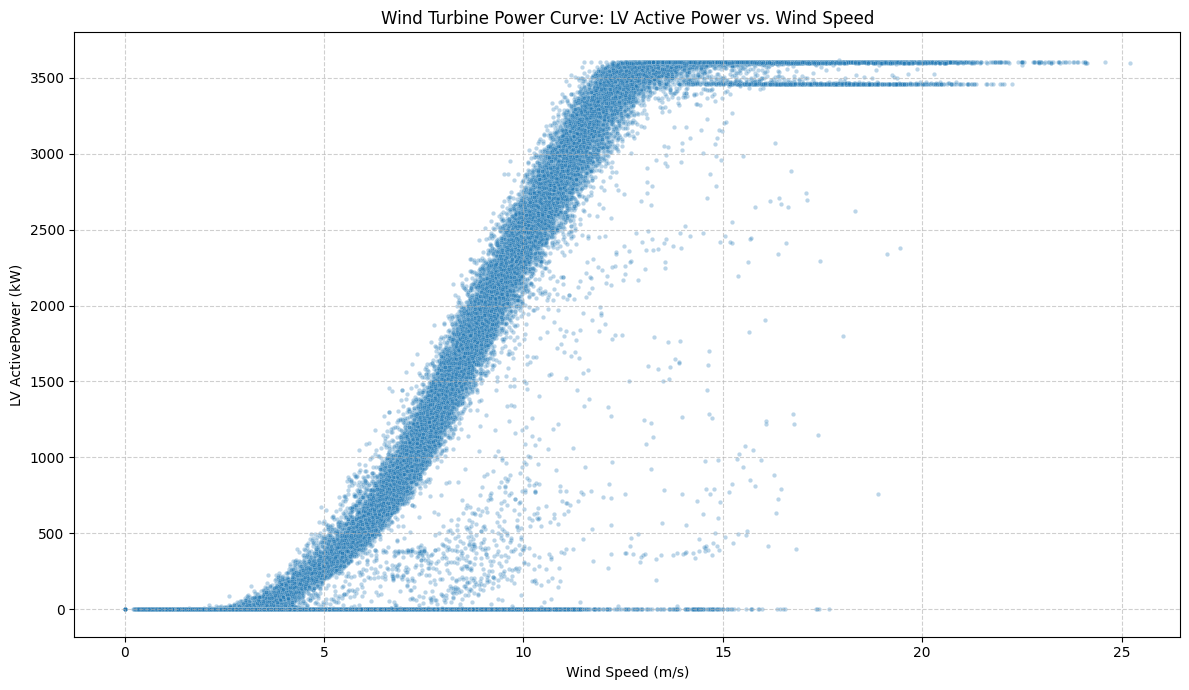

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot 1: Active Power vs. Wind Speed (Power Curve)
plt.figure(figsize=(12, 7))
sns.scatterplot(x='Wind Speed (m/s)', y='LV ActivePower (kW)', data=df, alpha=0.3, s=10)
plt.title('Wind Turbine Power Curve: LV Active Power vs. Wind Speed')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('LV ActivePower (kW)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

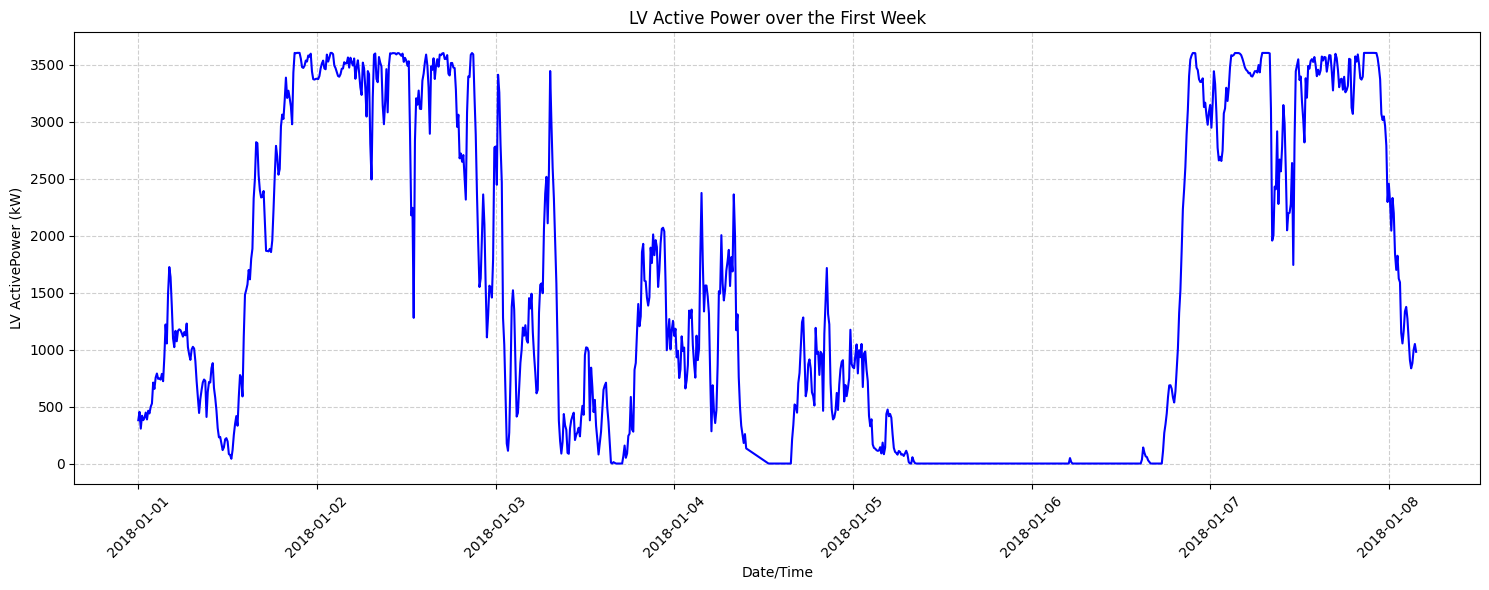

In [ ]:
# Plot 2: Active Power over Time (first few days for clarity)
# To avoid an overcrowded plot, let's visualize a subset, e.g., the first 7 days
plt.figure(figsize=(15, 6))
sns.lineplot(x='Date/Time', y='LV ActivePower (kW)', data=df.head(7 * 24 * 6), color='blue') # 7 days * 24 hours * 6 (10-min intervals)
plt.title('LV Active Power over the First Week')
plt.xlabel('Date/Time')
plt.ylabel('LV ActivePower (kW)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

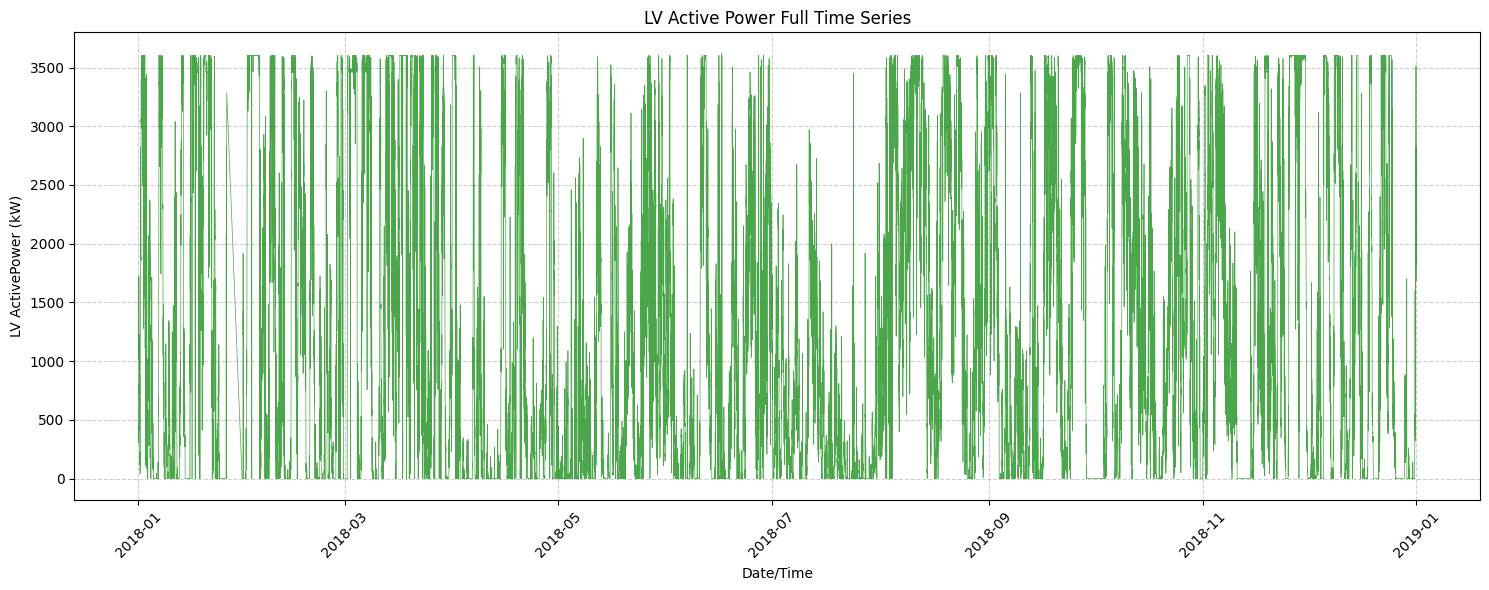

In [ ]:
# Plot 3: Active Power over Full Time Series (downsampled for performance)
# To show the overall trend, downsample the data (e.g., daily average) if the dataset is very large
# Here, we'll plot the full series, but for very large datasets, consider resampling for the plot
plt.figure(figsize=(15, 6))
plt.plot(df['Date/Time'], df['LV ActivePower (kW)'], color='green', alpha=0.7, linewidth=0.5)
plt.title('LV Active Power Full Time Series')
plt.xlabel('Date/Time')
plt.ylabel('LV ActivePower (kW)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Save cleaned dataset for feature engineering
clean_path = '/content/drive/MyDrive/Colab Notebooks/clean_data.csv'
df.to_csv(clean_path, index=False)
print(f"Cleaned dataset saved to {clean_path}")

Cleaned dataset saved to /content/drive/MyDrive/Colab Notebooks/clean_data.csv


# Load Cleaned Data


In [ ]:
import pandas as pd

clean_path = '/content/drive/MyDrive/Colab Notebooks/clean_data.csv'

## Load and Prepare Data


Load the `clean_data.csv` file, ensuring the 'Date/Time' column is parsed as datetime and set as the DataFrame index. Rename 'LV ActivePower (kW)' to 'wind_power_output' and 'Wind Speed (m/s)' to 'wind_speed_ms' for easier handling.


In [ ]:
df = pd.read_csv(clean_path, parse_dates=['Date/Time'], index_col='Date/Time')
df = df.rename(columns={'LV ActivePower (kW)': 'wind_power_output', 'Wind Speed (m/s)': 'wind_speed_ms'})

print("DataFrame after loading with datetime index and renamed columns:")
display(df.head())

DataFrame after loading with datetime index and renamed columns:


,wind_power_output,wind_speed_ms,Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50473 entries, 2018-01-01 00:00:00 to 2018-12-31 23:50:00
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   wind_power_output              50473 non-null  float64
 1   wind_speed_ms                  50473 non-null  float64
 2   Theoretical_Power_Curve (KWh)  50473 non-null  float64
 3   Wind Direction (°)             50473 non-null  float64
dtypes: float64(4)
memory usage: 1.9 MB


## Create Time-Based Features

Generate time-based features relevant for short-term forecasting from the datetime index, specifically 'hour_of_day' and 'day_of_week'. Avoid creating features like week, month, or quarter as per the constraints.


In [ ]:
df['hour_of_day'] = df.index.hour
df['day_of_week'] = df.index.dayofweek

print("DataFrame with new time-based features (hour_of_day, day_of_week):")
display(df.head())

DataFrame with new time-based features (hour_of_day, day_of_week):


,wind_power_output,wind_speed_ms,Theoretical_Power_Curve (KWh),Wind Direction (°),hour_of_day,day_of_week
Date/Time,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,0,0
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,0,0
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,0,0
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,0,0
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,0,0


## Creating Lagged Features

This cell creates lagged versions of selected variables to capture temporal dependencies in the data. For each specified lag value, past observations of wind power output and wind speed are shifted and stored as new columns in the DataFrame. These lagged features allow models to learn how previous values influence current outcomes, which is especially important for time series and forecasting tasks. After generating the new features, the first few rows of the updated dataset are displayed to verify that the lag columns were created correctly and to observe the expected missing values at the beginning caused by shifting.


In [ ]:
for lag in [1, 2, 6]:
    df[f'power_lag_{lag}'] = df['wind_power_output'].shift(lag)
    df[f'wind_speed_ms_lag_{lag}'] = df['wind_speed_ms'].shift(lag)

print("DataFrame with new lag features:")
display(df.head(10))

DataFrame with new lag features:


,wind_power_output,wind_speed_ms,Theoretical_Power_Curve (KWh),Wind Direction (°),hour_of_day,day_of_week,power_lag_1,wind_speed_ms_lag_1,power_lag_2,wind_speed_ms_lag_2,power_lag_6,wind_speed_ms_lag_6
Date/Time,,,,,,,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,0,0,380.047791,5.311336,NaN,NaN,NaN,NaN
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,0,0,453.769196,5.672167,380.047791,5.311336,NaN,NaN
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,0,0,306.376587,5.216037,453.769196,5.672167,NaN,NaN
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,0,0,419.645905,5.659674,306.376587,5.216037,NaN,NaN
2018-01-01 00:50:00,402.391998,5.604052,499.436385,264.578613,0,0,380.650696,5.577941,419.645905,5.659674,NaN,NaN
2018-01-01 01:00:00,447.605713,5.793008,557.372363,266.163605,1,0,402.391998,5.604052,380.650696,5.577941,380.047791,5.311336
2018-01-01 01:10:00,387.242188,5.306050,414.898179,257.949493,1,0,447.605713,5.793008,402.391998,5.604052,453.769196,5.672167
2018-01-01 01:20:00,463.651215,5.584629,493.677652,253.480698,1,0,387.242188,5.306050,447.605713,5.793008,306.376587,5.216037


## Creating Rolling Mean Features

This cell generates rolling mean features using a fixed time window to capture short term trends in the data. A window size of six data points is used, which corresponds to one hour when the data is recorded at ten minute intervals. Rolling averages of wind power output and wind speed are calculated and added as new columns to the dataset. These features help smooth out short term fluctuations and provide models with information about recent behavior patterns. The updated DataFrame is displayed to confirm that the rolling mean features have been created correctly and to observe the initial missing values introduced by the rolling calculation.


In [ ]:
window_size = 6 # 6 data points for a 1-hour window (10-minute intervals)

df[f'power_roll_mean_{window_size}'] = df['wind_power_output'].rolling(window=window_size).mean()
df[f'wind_speed_ms_roll_mean_{window_size}'] = df['wind_speed_ms'].rolling(window=window_size).mean()

print("DataFrame with new rolling mean features:")
display(df.head(10))

DataFrame with new rolling mean features:


,wind_power_output,wind_speed_ms,Theoretical_Power_Curve (KWh),Wind Direction (°),hour_of_day,day_of_week,power_lag_1,wind_speed_ms_lag_1,power_lag_2,wind_speed_ms_lag_2,power_lag_6,wind_speed_ms_lag_6,power_roll_mean_6,wind_speed_ms_roll_mean_6
Date/Time,,,,,,,,,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,0,0,380.047791,5.311336,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,0,0,453.769196,5.672167,380.047791,5.311336,NaN,NaN,NaN,NaN
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,0,0,306.376587,5.216037,453.769196,5.672167,NaN,NaN,NaN,NaN
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,0,0,419.645905,5.659674,306.376587,5.216037,NaN,NaN,NaN,NaN
2018-01-01 00:50:00,402.391998,5.604052,499.436385,264.578613,0,0,380.650696,5.577941,419.645905,5.659674,NaN,NaN,390.480362,5.506868
2018-01-01 01:00:00,447.605713,5.793008,557.372363,266.163605,1,0,402.391998,5.604052,380.650696,5.577941,380.047791,5.311336,401.740016,5.587146
2018-01-01 01:10:00,387.242188,5.306050,414.898179,257.949493,1,0,447.605713,5.793008,402.391998,5.604052,453.769196,5.672167,390.652181,5.526127
2018-01-01 01:20:00,463.651215,5.584629,493.677652,253.480698,1,0,387.242188,5.306050,447.605713,5.793008,306.376587,5.216037,416.864619,5.587559


## Handling Missing Values After Feature Engineering

This cell handles missing values created during feature engineering. The shape of the DataFrame is printed before removing missing values to show the original size. All rows containing missing values are then dropped to ensure the dataset is clean and ready for modeling. The updated shape is printed again to show how many rows were removed. Finally, the first few rows of the cleaned DataFrame are displayed to confirm that the missing values have been successfully handled.


In [ ]:
print(f"Shape of DataFrame before dropping NaNs: {df.shape}")
df.dropna(inplace=True)
print(f"Shape of DataFrame after dropping NaNs: {df.shape}")
print("DataFrame after handling missing values:")
display(df.head())

Shape of DataFrame before dropping NaNs: (50473, 14)
Shape of DataFrame after dropping NaNs: (50467, 14)
DataFrame after handling missing values:


,wind_power_output,wind_speed_ms,Theoretical_Power_Curve (KWh),Wind Direction (°),hour_of_day,day_of_week,power_lag_1,wind_speed_ms_lag_1,power_lag_2,wind_speed_ms_lag_2,power_lag_6,wind_speed_ms_lag_6,power_roll_mean_6,wind_speed_ms_roll_mean_6
Date/Time,,,,,,,,,,,,,,
2018-01-01 01:00:00,447.605713,5.793008,557.372363,266.163605,1,0,402.391998,5.604052,380.650696,5.577941,380.047791,5.311336,401.740016,5.587146
2018-01-01 01:10:00,387.242188,5.306050,414.898179,257.949493,1,0,447.605713,5.793008,402.391998,5.604052,453.769196,5.672167,390.652181,5.526127
2018-01-01 01:20:00,463.651215,5.584629,493.677652,253.480698,1,0,387.242188,5.306050,447.605713,5.793008,306.376587,5.216037,416.864619,5.587559
2018-01-01 01:30:00,439.725708,5.523228,475.706783,258.723785,1,0,463.651215,5.584629,387.242188,5.306050,419.645905,5.659674,420.211253,5.564818
2018-01-01 01:40:00,498.181702,5.724116,535.841397,251.850998,1,0,439.725708,5.523228,463.651215,5.584629,380.650696,5.577941,439.799754,5.589180


## Verifying the Final Dataset Structure

This cell provides a final check of the prepared dataset before modeling. It prints the shape of the DataFrame to confirm the total number of rows and columns after all preprocessing steps. It also lists all column names to clearly show the features that will be used in the next stages. This verification step helps ensure that feature engineering and data cleaning were applied correctly and that the dataset is ready for analysis or model training.


In [ ]:
print(f"Final DataFrame shape: {df.shape}")
print("Final DataFrame columns:")
for col in df.columns:
    print(f"- {col}")

Final DataFrame shape: (50467, 14)
Final DataFrame columns:
- wind_power_output
- wind_speed_ms
- Theoretical_Power_Curve (KWh)
- Wind Direction (°)
- hour_of_day
- day_of_week
- power_lag_1
- wind_speed_ms_lag_1
- power_lag_2
- wind_speed_ms_lag_2
- power_lag_6
- wind_speed_ms_lag_6
- power_roll_mean_6
- wind_speed_ms_roll_mean_6


## Saving the Processed Dataset

This cell saves the fully processed DataFrame to a CSV file in Google Drive so it can be reused later without repeating preprocessing steps. Storing the dataset at this stage preserves all engineered features and cleaned data. After saving the file, the cell prints the final shape of the DataFrame and lists all column names to confirm that the correct data has been stored. This step ensures that the dataset is ready for modeling, analysis, or sharing in future work.



In [ ]:
output_path = '/content/drive/MyDrive/Colab Notebooks/features_v1.csv'
df.to_csv(output_path)

print(f"DataFrame saved to: {output_path}")
print(f"Final DataFrame shape: {df.shape}")
print("Final DataFrame columns:")
for col in df.columns:
    print(f"- {col}")

DataFrame saved to: /content/drive/MyDrive/Colab Notebooks/features_v1.csv
Final DataFrame shape: (50467, 14)
Final DataFrame columns:
- wind_power_output
- wind_speed_ms
- Theoretical_Power_Curve (KWh)
- Wind Direction (°)
- hour_of_day
- day_of_week
- power_lag_1
- wind_speed_ms_lag_1
- power_lag_2
- wind_speed_ms_lag_2
- power_lag_6
- wind_speed_ms_lag_6
- power_roll_mean_6
- wind_speed_ms_roll_mean_6


## Summary:

### Data Analysis Key Findings

*   **Feature Engineering and NaN Handling:**
    *   Initial attempts to remove NaNs were unsuccessful because the lag and rolling features were not present in the DataFrame.
    *   Time-based features (`hour_of_day`, `day_of_week`), lag features (e.g., `power_lag_1`, `wind_speed_ms_lag_6`), and rolling mean features (e.g., `power_roll_mean_6`, `wind_speed_ms_roll_mean_6` with a window size of 6) were successfully re-created and added to the DataFrame.
    *   After re-creating the features, `6` rows containing NaN values (introduced by these operations) were successfully removed, reducing the DataFrame from `(50473, 14)` to `(50467, 14)`.
*   **Feature Dataset Persistence:**
    *   The cleaned and feature-engineered DataFrame, with a final shape of `(50467, 14)`, was successfully saved to a CSV file named `features_v1.csv` at `/content/drive/MyDrive/Colab Notebooks/features_v1.csv`. The index was not included in the saved file.
    *   The dataset confirmed the presence of all expected columns: original features (`wind_power_output`, `wind_speed_ms`, `Theoretical_Power_Curve (KWh)`, `Wind Direction (\u00b0)`), time-based features (`hour_of_day`, `day_of_week`), and the newly engineered lag and rolling mean features.
*   **Explanation of Time-Series Features:**
    *   A comprehensive markdown explanation was provided, clarifying the distinction between lag features and rolling statistics.
    *   Lag features were described as capturing specific past point values, useful for immediate dependencies.
    *   Rolling means were explained as capturing trends and smoothing out noise over a recent period, providing a more generalized view of recent behavior.
    *   The explanation emphasized that using both types of features provides complementary information, crucial for robust time-series analysis and prediction by leveraging both precise historical points and smoothed recent trends.

### Insights or Next Steps

*   The dataset is now thoroughly cleaned and enriched with relevant temporal features, making it suitable for training predictive models for wind power output.
*   The combination of lag features and rolling means provides a robust foundation for capturing both short-term dependencies and underlying trends in time-series data, which is essential for accurate forecasting of dynamic systems like wind power generation.


# Experimental Design Overview

This study follows a structured experimental approach to evaluate the impact of
SHAP-based feature refinement on short-term wind power forecasting performance.

The experiments are organised as follows:
- Experiment 1: Baseline feature set with machine learning model
- Experiment 2: SHAP analysis to identify influential features
- Experiment 3: Feature refinement guided by SHAP insights
- Experiment 4: Retraining and performance comparison


# Baseline Models

## Load Data

In [ ]:
features_path = '/content/drive/MyDrive/Colab Notebooks/features_v1.csv'

df = pd.read_csv(features_path, parse_dates=['Date/Time'])
df = df.set_index('Date/Time')

print("Feature dataset loaded successfully.")
print("Dataset shape:", df.shape)
df.head()


Feature dataset loaded successfully.
Dataset shape: (50467, 14)


,wind_power_output,wind_speed_ms,Theoretical_Power_Curve (KWh),Wind Direction (°),hour_of_day,day_of_week,power_lag_1,wind_speed_ms_lag_1,power_lag_2,wind_speed_ms_lag_2,power_lag_6,wind_speed_ms_lag_6,power_roll_mean_6,wind_speed_ms_roll_mean_6
Date/Time,,,,,,,,,,,,,,
2018-01-01 01:00:00,447.605713,5.793008,557.372363,266.163605,1,0,402.391998,5.604052,380.650696,5.577941,380.047791,5.311336,401.740016,5.587146
2018-01-01 01:10:00,387.242188,5.306050,414.898179,257.949493,1,0,447.605713,5.793008,402.391998,5.604052,453.769196,5.672167,390.652181,5.526127
2018-01-01 01:20:00,463.651215,5.584629,493.677652,253.480698,1,0,387.242188,5.306050,447.605713,5.793008,306.376587,5.216037,416.864619,5.587559
2018-01-01 01:30:00,439.725708,5.523228,475.706783,258.723785,1,0,463.651215,5.584629,387.242188,5.306050,419.645905,5.659674,420.211253,5.564818
2018-01-01 01:40:00,498.181702,5.724116,535.841397,251.850998,1,0,439.725708,5.523228,463.651215,5.584629,380.650696,5.577941,439.799754,5.589180


## Splitting the Data into Training and Testing Sets

This cell divides the dataset into training and testing subsets based on time order. Eighty percent of the data is used for training and the remaining twenty percent is reserved for testing. The split is performed chronologically to preserve the temporal structure of the data, which is important for time series and forecasting tasks. The shapes of both subsets are printed to confirm the split, and the first few rows of each set are displayed to verify that the separation has been applied correctly.


In [ ]:
# Calculate the split point (e.g., 80% for training, 20% for testing)
split_point = int(len(df) * 0.8)

# Split the data chronologically
train_df = df.iloc[:split_point]
test_df = df.iloc[split_point:]

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

print("\nFirst 5 rows of training data:")
display(train_df.head())

print("\nFirst 5 rows of test data:")
display(test_df.head())

Training set shape: (40373, 14)
Test set shape: (10094, 14)

First 5 rows of training data:


,wind_power_output,wind_speed_ms,Theoretical_Power_Curve (KWh),Wind Direction (°),hour_of_day,day_of_week,power_lag_1,wind_speed_ms_lag_1,power_lag_2,wind_speed_ms_lag_2,power_lag_6,wind_speed_ms_lag_6,power_roll_mean_6,wind_speed_ms_roll_mean_6
Date/Time,,,,,,,,,,,,,,
2018-01-01 01:00:00,447.605713,5.793008,557.372363,266.163605,1,0,402.391998,5.604052,380.650696,5.577941,380.047791,5.311336,401.740016,5.587146
2018-01-01 01:10:00,387.242188,5.306050,414.898179,257.949493,1,0,447.605713,5.793008,402.391998,5.604052,453.769196,5.672167,390.652181,5.526127
2018-01-01 01:20:00,463.651215,5.584629,493.677652,253.480698,1,0,387.242188,5.306050,447.605713,5.793008,306.376587,5.216037,416.864619,5.587559
2018-01-01 01:30:00,439.725708,5.523228,475.706783,258.723785,1,0,463.651215,5.584629,387.242188,5.306050,419.645905,5.659674,420.211253,5.564818
2018-01-01 01:40:00,498.181702,5.724116,535.841397,251.850998,1,0,439.725708,5.523228,463.651215,5.584629,380.650696,5.577941,439.799754,5.589180



First 5 rows of test data:


,wind_power_output,wind_speed_ms,Theoretical_Power_Curve (KWh),Wind Direction (°),hour_of_day,day_of_week,power_lag_1,wind_speed_ms_lag_1,power_lag_2,wind_speed_ms_lag_2,power_lag_6,wind_speed_ms_lag_6,power_roll_mean_6,wind_speed_ms_roll_mean_6
Date/Time,,,,,,,,,,,,,,
2018-10-18 23:00:00,0.0,2.430004,0.0,215.388702,23,3,0.0,2.458950,0.0,2.289220,0.0,2.071293,0.0,2.177257
2018-10-18 23:10:00,0.0,2.387723,0.0,227.553604,23,3,0.0,2.430004,0.0,2.458950,0.0,1.833210,0.0,2.269676
2018-10-18 23:20:00,0.0,2.038939,0.0,241.738693,23,3,0.0,2.387723,0.0,2.430004,0.0,1.898071,0.0,2.293154
2018-10-18 23:30:00,0.0,2.238692,0.0,216.348404,23,3,0.0,2.038939,0.0,2.387723,0.0,2.154090,0.0,2.307255
2018-10-18 23:40:00,0.0,2.606488,0.0,201.431503,23,3,0.0,2.238692,0.0,2.038939,0.0,2.289220,0.0,2.360133


## Creating a Naive Baseline Forecast

This cell creates a simple baseline forecast using a naive approach. The target variable is defined as wind power output, and a copy of the test dataset is created to avoid unintended modifications. The naive forecast is generated by shifting the actual target values by one time step, meaning the previous observation is used to predict the next one. For the first test point, the last value from the training set is used to maintain continuity. The forecast is then added to the test dataset, and valid values are selected to ensure consistency. This baseline model serves as a reference point for evaluating more advanced forecasting models later.


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define the target variable
target = 'wind_power_output'

# Create a copy of test_df to avoid SettingWithCopyWarning
test_df = test_df.copy()

# Create the naive forecast
naive_forecast = test_df[target].shift(1)
naive_forecast.iloc[0] = train_df[target].iloc[-1]

# Assign forecast to test_df
test_df['naive_forecast'] = naive_forecast

# Remove any NaNs (safety)
valid_idx = test_df['naive_forecast'].notna()

y_true = test_df.loc[valid_idx, target]
y_pred = test_df.loc[valid_idx, 'naive_forecast']

print("Naive forecast generated successfully.")
display(test_df[[target, 'naive_forecast']].head())


Naive forecast generated successfully.


,wind_power_output,naive_forecast
Date/Time,,
2018-10-18 23:00:00,0.0,0.0
2018-10-18 23:10:00,0.0,0.0
2018-10-18 23:20:00,0.0,0.0
2018-10-18 23:30:00,0.0,0.0
2018-10-18 23:40:00,0.0,0.0


### Interpretation of Naive Baseline Behavior and Implications

The naive (persistence) model, which forecasts the next observation as the immediately preceding one, fundamentally operates without learning any parameters from the data. Consequently, the concepts of **overfitting** (where a model learns noise in the training data to the detriment of generalization) and **underfitting** (where a model is too simple to capture underlying patterns) do not directly apply. Instead, the naive baseline is characterized by **high bias** and **low capacity**. Its high bias stems from the strong and often inaccurate assumption that future values are merely repetitions of the most recent past. Its low capacity means it possesses no ability to learn complex relationships, temporal dependencies, or the influence of exogenous variables. The observed error metrics (MAE, RMSE, MAPE) and the visual lag in its predictions quantify this inherent high bias, highlighting the model's substantial room for improvement. This establishes a critical lower bound for performance, thereby motivating the necessity of employing more sophisticated machine learning models, which possess greater capacity to learn and mitigate this bias by capturing the intricate dynamics of wind power generation.

## Defining True Values and Predictions

This cell extracts the actual target values and the corresponding predicted values from the test dataset. The true values represent the real wind power output, while the predictions come from the naive forecast generated earlier. Selecting only valid indices ensures that both arrays are aligned and free from missing values. These variables are prepared for use in performance evaluation metrics in the next steps.


In [ ]:
# Define ground truth and predictions
y_true = test_df.loc[valid_idx, target]
y_pred = test_df.loc[valid_idx, 'naive_forecast']


## Evaluating the Naive Forecast Performance

This cell evaluates the performance of the naive baseline forecast using standard regression metrics. Mean Absolute Error and Root Mean Squared Error measure the average prediction error and the impact of larger errors. Mean Absolute Percentage Error is calculated using a custom function to safely handle cases where true values are zero. These metrics provide a quantitative assessment of how well the naive forecast performs. The results are printed for easy interpretation and also stored in a summary table, which can be used later for comparison with more advanced models.


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    non_zero_indices = y_true != 0
    if non_zero_indices.sum() == 0:
        return np.nan
    return np.mean(
        np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])
    ) * 100

mape = calculate_mape(y_true, y_pred)

print("Naive Baseline Performance:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")

metrics_summary = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE'],
    'Naive Baseline': [mae, rmse, mape]
})

metrics_summary


Naive Baseline Performance:
MAE  : 126.5364
RMSE : 228.5290
MAPE : 65.41%


,Metric,Naive Baseline
0,MAE,126.536440
1,RMSE,228.529000
2,MAPE,65.408212


### Interpretation of Visualization

The plot illustrates the performance of the naive baseline model, which predicts the next value as the last observed value. While it generally follows the trend of the actual wind power output, its inherent one-step lag is clearly visible, especially during periods of significant change, highlighting the model's limitation in capturing rapid fluctuations within the time series.

## Visual Comparison of Actual and Naive Forecast

This cell visualizes the performance of the naive forecast by comparing it with the actual wind power output over a short time window from the test dataset. A limited window is selected to make the plot clear and easy to interpret, focusing on the first two days of test data. The actual values and the naive predictions are plotted on the same graph to highlight differences over time. This visual comparison helps in understanding how closely the naive forecast follows real trends and where it fails to capture sudden changes, providing intuition beyond numerical evaluation metrics.


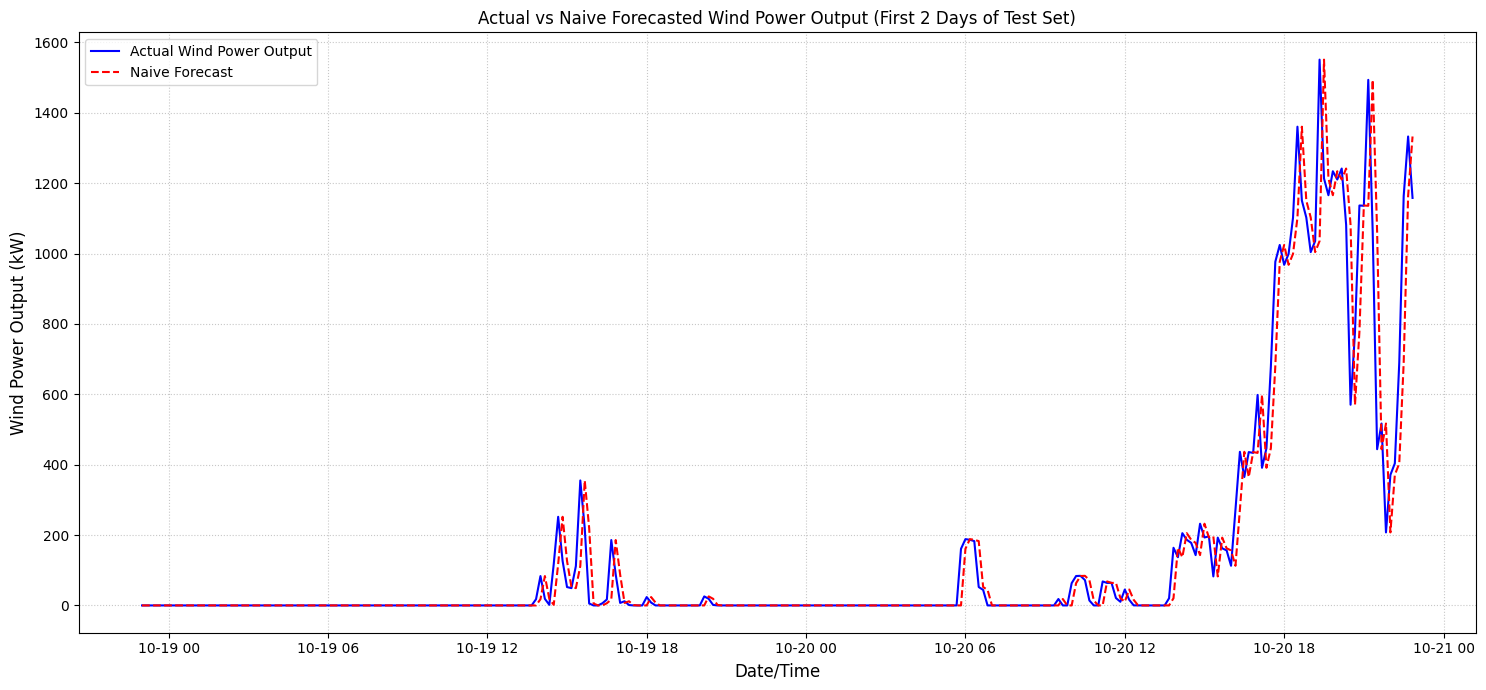

In [ ]:
import matplotlib.pyplot as plt

# Select a short window from the test set for visualization (e.g., first 2 days)
# 10-minute resolution means 6 points per hour, so 24 hours * 2 days * 6 points/hour = 288 points
plot_window = 288

plt.figure(figsize=(15, 7))
plt.plot(y_true.index[:plot_window], y_true.iloc[:plot_window], label='Actual Wind Power Output', color='blue')
plt.plot(y_pred.index[:plot_window], y_pred.iloc[:plot_window], label='Naive Forecast', color='red', linestyle='--')

plt.title('Actual vs Naive Forecasted Wind Power Output (First 2 Days of Test Set)')
plt.xlabel('Date/Time', fontsize=12)
plt.ylabel('Wind Power Output (kW)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

## Training and Forecasting with the ARIMA Model

This cell trains an ARIMA model using the training portion of the dataset to capture temporal patterns in wind power output. The chosen model configuration uses autoregressive and moving average components along with differencing to handle non stationary behavior in the time series. After training, a summary of the fitted model is displayed to review key statistics and parameter estimates. The model is then used to generate forecasts for the entire test period. The predicted values are aligned with the test dataset index and stored as a new column, making them ready for evaluation and comparison with other forecasting approaches.


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Train ARIMA model
# Note: This might take a few minutes depending on the dataset size
print('Training ARIMA(5,1,0) model...')
model_arima = ARIMA(train_df[target], order=(5,1,0))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

# Forecast
print('Generating ARIMA forecasts...')
# Forecasting on the test set indices
arima_forecast = model_arima_fit.forecast(steps=len(test_df))

# Align indices
arima_forecast.index = test_df.index
test_df['arima_forecast'] = arima_forecast


Training ARIMA(5,1,0) model...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:      wind_power_output   No. Observations:                40373
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -279471.374
Date:                Sun, 01 Feb 2026   AIC                         558954.749
Time:                        17:45:10   BIC                         559006.384
Sample:                             0   HQIC                        558971.086
                              - 40373                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0053      0.002     -2.636      0.008      -0.009      -0.001
ar.L2         -0.1107      0.002    -48.695      0.000      -0.115      -0.106
ar.L3         -0.0585      0.002    -27.138      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## ARIMA Model Diagnostics

This cell generates diagnostic plots for the trained ARIMA model to assess its quality and assumptions. The diagnostics include residual analysis, distribution checks, and autocorrelation plots, which help determine whether the model has captured the underlying patterns in the data effectively. Visual inspection of these plots can reveal issues such as remaining autocorrelation, non normal residuals, or variance instability. This step is important for validating the reliability of the ARIMA model before relying on its forecasts.


Plotting ARIMA diagnostics...


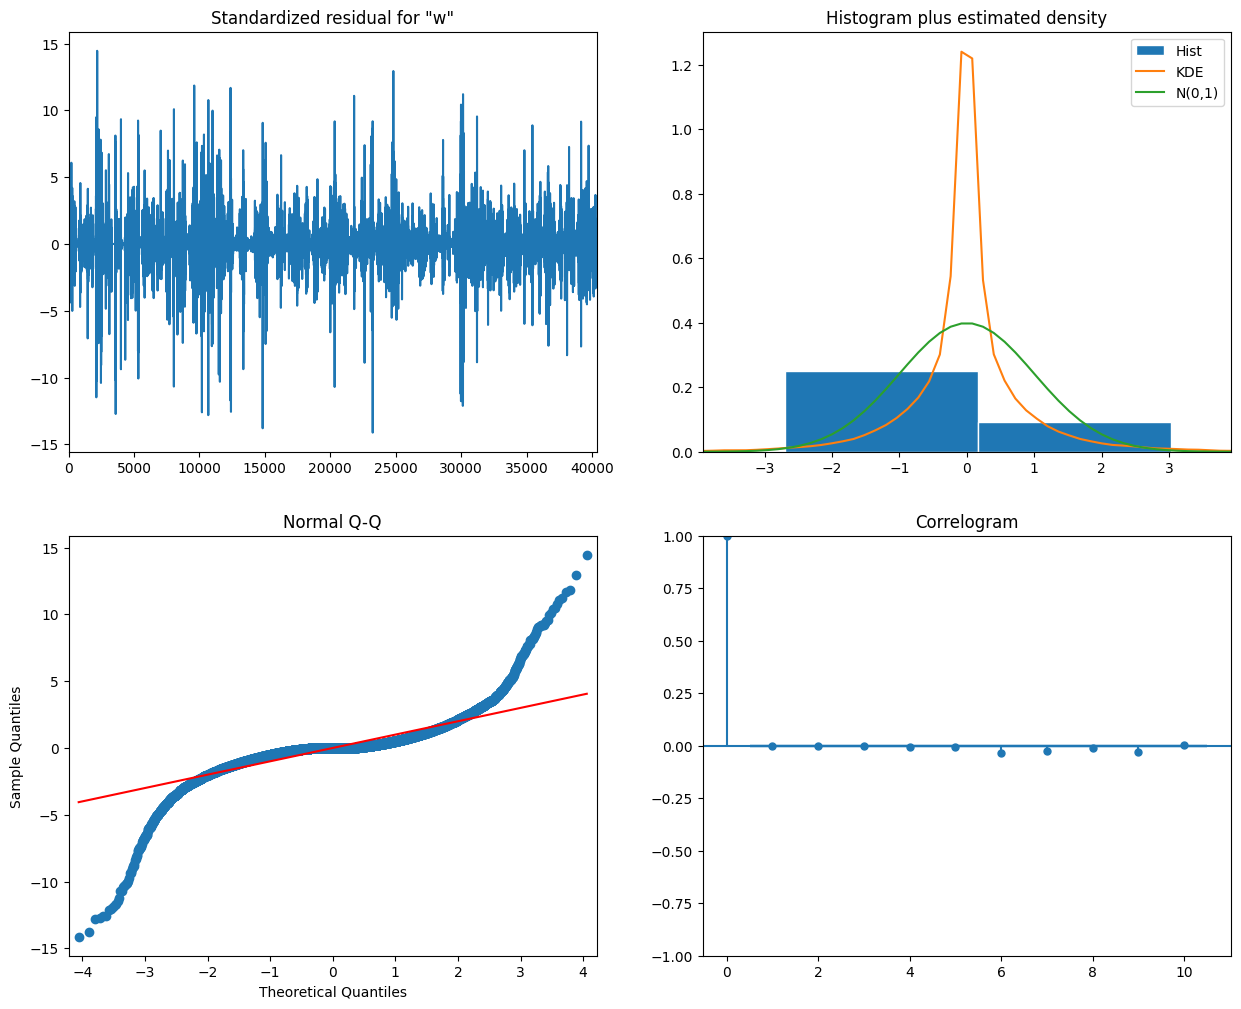

In [ ]:
# ARIMA Diagnostics
import matplotlib.pyplot as plt
print('Plotting ARIMA diagnostics...')
model_arima_fit.plot_diagnostics(figsize=(15, 12))
plt.show()


## Training and Forecasting with the Prophet Model

This cell applies the Prophet forecasting model to the wind power output data. Since Prophet requires a specific data format, the training and testing datasets are reshaped to include a datetime column named ds and a target column named y. Logging is adjusted to reduce unnecessary warning messages during training. The Prophet model is then initialized and trained on the historical training data. Forecasts are generated for the timestamps in the test set, and the predicted values are extracted and added back to the test dataset. This step enables direct comparison of Prophet forecasts with other models and actual observations.


In [ ]:
from prophet import Prophet
import logging
logging.getLogger('prophet').setLevel(logging.WARNING)

# Prophet expects dataset with columns 'ds' and 'y'
prophet_train = train_df.reset_index()[['Date/Time', target]].rename(columns={'Date/Time': 'ds', target: 'y'})
prophet_test = test_df.reset_index()[['Date/Time', target]].rename(columns={'Date/Time': 'ds', target: 'y'})

# Initialize and train Prophet
print('Training Prophet model...')
m = Prophet()
m.fit(prophet_train)

# Create future dataframe for prediction (which is just the test set times)
future = prophet_test[['ds']]
print('Generating Prophet forecasts...')
forecast = m.predict(future)

# Assign predictions back to test_df
# Prophet returns a dataframe with 'yhat'
test_df['prophet_forecast'] = forecast['yhat'].values


Training Prophet model...
Generating Prophet forecasts...


## Visualizing the Prophet Forecast

This cell generates a plot of the forecast produced by the Prophet model. The visualization shows the predicted wind power output over time along with trend components learned from the data. Plotting the forecast helps in understanding how Prophet models overall patterns and future behavior. This visual inspection is useful for assessing whether the forecast aligns with expected trends before performing detailed quantitative evaluation.


Plotting Prophet forecast...


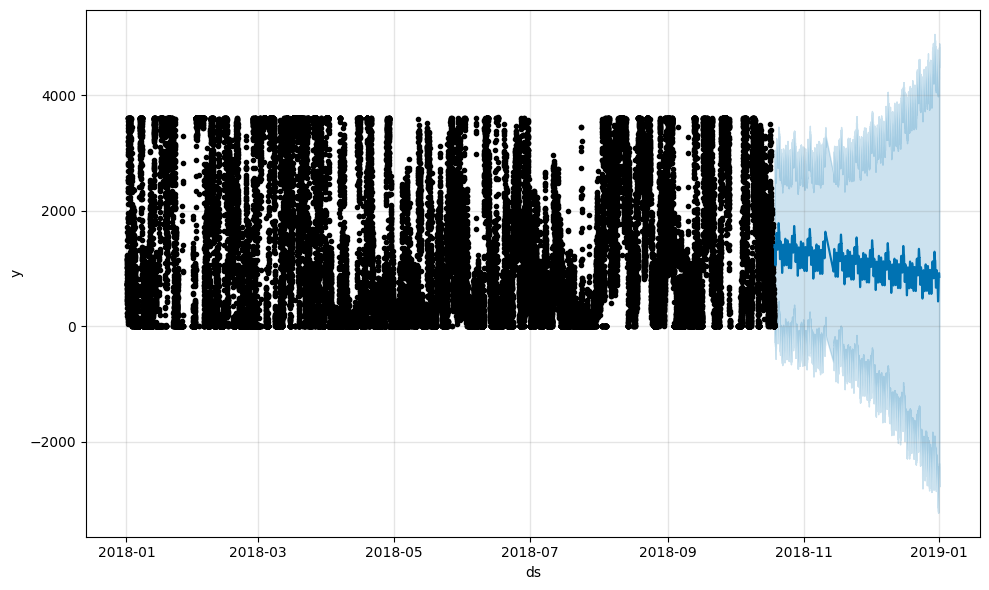

In [ ]:
# Prophet Forecast Plot
print('Plotting Prophet forecast...')
fig1 = m.plot(forecast)
plt.show()

## Visualizing Prophet Model Components

This cell displays the individual components learned by the Prophet model during training. The plots typically include the overall trend and any seasonal patterns present in the data. Examining these components helps in understanding how different time related factors contribute to the forecast. This step provides insight into the internal structure of the Prophet model and supports better interpretation of its predictions.


Plotting Prophet components...


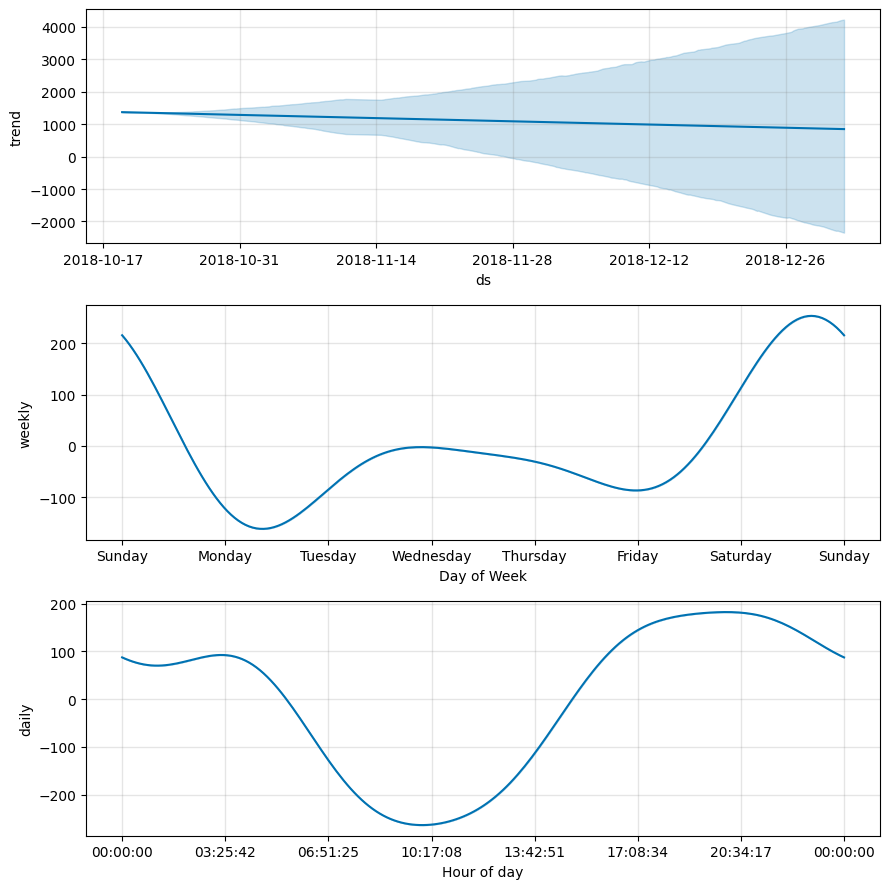

In [ ]:
# Prophet Components Plot
print('Plotting Prophet components...')
fig2 = m.plot_components(forecast)
plt.show()

## Comparing Baseline Forecasting Models

This cell evaluates and compares the performance of multiple baseline forecasting models using the test dataset. Error metrics are calculated for the ARIMA and Prophet forecasts and then added to the existing summary table alongside the naive baseline results. This allows all models to be compared using the same evaluation criteria. The final comparison table is displayed to clearly show the relative performance of each approach. A visualization is also created for the first two days of the test period, where actual wind power output is plotted together with predictions from the naive, ARIMA, and Prophet models. This combined view helps in visually assessing how closely each model follows the real data and highlights differences in their forecasting behavior.


Final Model Comparison:


,Metric,Naive Baseline,ARIMA,Prophet
0,MAE,126.536440,1467.657458,1151.696996
1,RMSE,228.529000,1988.639493,1387.900083
2,MAPE,65.408212,100.000000,1396.830715


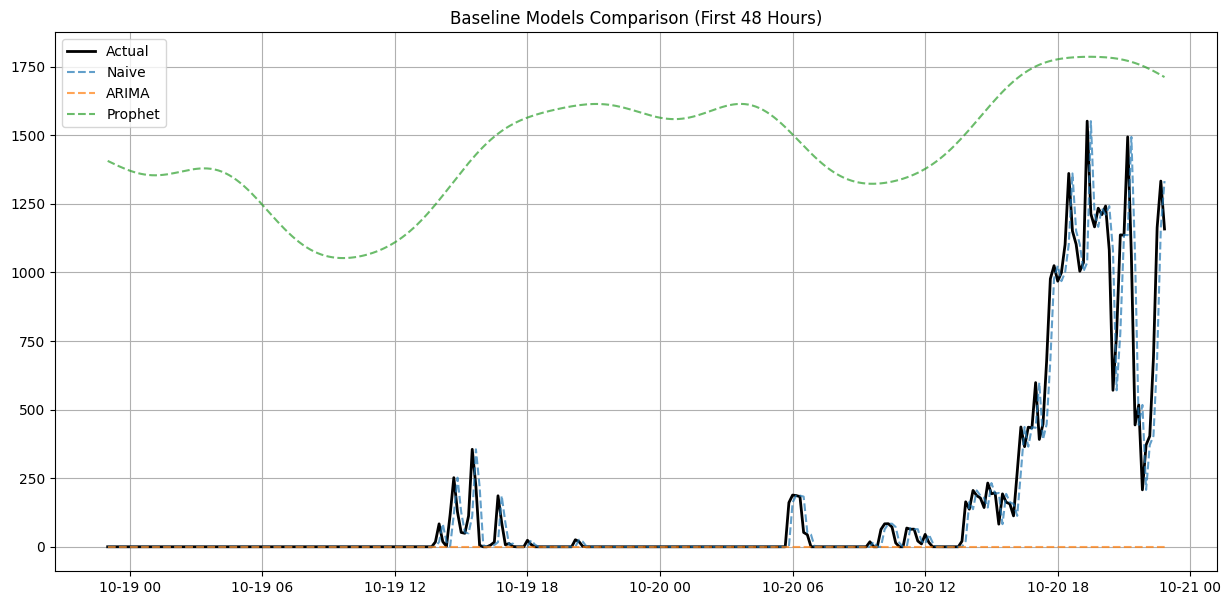

In [ ]:
# Evaluate ARIMA
mae_arima = mean_absolute_error(y_true, test_df['arima_forecast'])
rmse_arima = np.sqrt(mean_squared_error(y_true, test_df['arima_forecast']))
mape_arima = calculate_mape(y_true, test_df['arima_forecast'])

# Evaluate Prophet
mae_prophet = mean_absolute_error(y_true, test_df['prophet_forecast'])
rmse_prophet = np.sqrt(mean_squared_error(y_true, test_df['prophet_forecast']))
mape_prophet = calculate_mape(y_true, test_df['prophet_forecast'])

# Add to comparison table
metrics_summary['ARIMA'] = [mae_arima, rmse_arima, mape_arima]
metrics_summary['Prophet'] = [mae_prophet, rmse_prophet, mape_prophet]

print('Final Model Comparison:')
display(metrics_summary)

# Visualization
plt.figure(figsize=(15, 7))
plot_window = 288 # First 2 days
plt.plot(y_true.index[:plot_window], y_true.iloc[:plot_window], label='Actual', color='black', linewidth=2)
plt.plot(y_true.index[:plot_window], test_df['naive_forecast'].iloc[:plot_window], label='Naive', linestyle='--', alpha=0.7)
plt.plot(y_true.index[:plot_window], test_df['arima_forecast'].iloc[:plot_window], label='ARIMA', linestyle='--', alpha=0.7)
plt.plot(y_true.index[:plot_window], test_df['prophet_forecast'].iloc[:plot_window], label='Prophet', linestyle='--', alpha=0.7)
plt.title('Baseline Models Comparison (First 48 Hours)')
plt.legend()
plt.grid(True)
plt.show()


# Ml models


# Load Data

In [ ]:
import pandas as pd
import numpy as np
features_path = '/content/drive/MyDrive/Colab Notebooks/features_v1.csv'

df = pd.read_csv(features_path, parse_dates=['Date/Time'])
df = df.set_index('Date/Time')

print("Feature dataset loaded successfully.")
print("Dataset shape:", df.shape)
df.head()


Feature dataset loaded successfully.
Dataset shape: (50467, 14)


,wind_power_output,wind_speed_ms,Theoretical_Power_Curve (KWh),Wind Direction (°),hour_of_day,day_of_week,power_lag_1,wind_speed_ms_lag_1,power_lag_2,wind_speed_ms_lag_2,power_lag_6,wind_speed_ms_lag_6,power_roll_mean_6,wind_speed_ms_roll_mean_6
Date/Time,,,,,,,,,,,,,,
2018-01-01 01:00:00,447.605713,5.793008,557.372363,266.163605,1,0,402.391998,5.604052,380.650696,5.577941,380.047791,5.311336,401.740016,5.587146
2018-01-01 01:10:00,387.242188,5.306050,414.898179,257.949493,1,0,447.605713,5.793008,402.391998,5.604052,453.769196,5.672167,390.652181,5.526127
2018-01-01 01:20:00,463.651215,5.584629,493.677652,253.480698,1,0,387.242188,5.306050,447.605713,5.793008,306.376587,5.216037,416.864619,5.587559
2018-01-01 01:30:00,439.725708,5.523228,475.706783,258.723785,1,0,463.651215,5.584629,387.242188,5.306050,419.645905,5.659674,420.211253,5.564818
2018-01-01 01:40:00,498.181702,5.724116,535.841397,251.850998,1,0,439.725708,5.523228,463.651215,5.584629,380.650696,5.577941,439.799754,5.589180


### Explanation of Model Choice: XGBoost for Tabular Time-Series Data

XGBoost (eXtreme Gradient Boosting) and LightGBM are powerful gradient boosting frameworks widely used for tabular data, including time-series problems. Here's why they are often preferred:

1.  **High Performance**: They consistently deliver state-of-the-art performance on a wide range of tasks due to their ensemble learning approach and optimized algorithms.
2.  **Handling Heterogeneous Features**: They can effectively handle a mix of numerical and categorical features (after appropriate encoding) without extensive feature scaling, which is common in tabular data.
3.  **Robustness to Outliers**: Gradient Boosting models are generally robust to outliers compared to some other models.
4.  **Feature Importance**: They provide measures of feature importance, which can be valuable for understanding the driving factors in your time series.
5.  **Speed and Scalability**: Both libraries are highly optimized for speed and can handle large datasets efficiently.
6.  **Flexibility**: They can model complex non-linear relationships that might exist in time-series data, which simpler linear models might miss.

While they don't inherently handle temporal dependencies like dedicated time-series models (e.g., ARIMA, LSTMs), with proper feature engineering (like lags, rolling means, time-based features already present in your `df`), they can capture these relationships effectively and often outperform traditional time-series methods on rich tabular time-series datasets.

## Defining Features and Splitting Data for Supervised Learning

This cell prepares the dataset for supervised machine learning models. The target variable is defined as wind power output, and all remaining columns are selected as input features. The features and target are separated into independent and dependent variables. The data is then split into training and testing sets using a fixed ratio while preserving the original order of observations. Printing the shapes of the resulting datasets confirms that the split has been performed correctly and that the data is ready for model training and evaluation.


In [ ]:
TARGET = 'wind_power_output'
FEATURES = [col for col in df.columns if col != TARGET]

X = df[FEATURES]
y = df[TARGET]

split_ratio = 0.8
split_index = int(len(df) * split_ratio)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (40373, 13)
Test shape: (10094, 13)


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost model...")
model.fit(X_train, y_train)
print("Training complete.")


Training XGBoost model...
Training complete.


# Training an XGBoost Regression Model

This cell initializes and trains an XGBoost regression model to predict wind power output using the prepared feature set. The model is configured with common hyperparameters that balance learning speed, model complexity, and generalization. Subsampling options are used to reduce overfitting, and a fixed random state ensures reproducibility. The model is trained on the training data, and status messages are printed to confirm the start and completion of the training process. This step builds a powerful machine learning model capable of capturing complex nonlinear relationships in the data.


In [ ]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# MAPE (filtered to avoid division by zero)
non_zero_idx = y_test != 0
mape = np.mean(
    np.abs((y_test[non_zero_idx] - y_pred[non_zero_idx]) / y_test[non_zero_idx])
) * 100

print("XGBoost Performance on Test Set:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.2f}")


XGBoost Performance on Test Set:
MAE  : 55.13
RMSE : 102.51
MAPE : 60.33%
R²   : 0.99


## Analyzing Feature Importance from the XGBoost Model

This cell extracts and analyzes feature importance scores from the trained XGBoost model. The importance values indicate how much each input feature contributes to the model’s predictions. These scores are stored in a pandas Series, indexed by feature names, and sorted in descending order to highlight the most influential features. Displaying the top features helps in understanding which variables have the greatest impact on wind power output and supports model interpretation and feature selection decisions.


In [ ]:
feature_importances = pd.Series(
    model.feature_importances_,
    index=FEATURES
).sort_values(ascending=False)

feature_importances.head(10)


,0
power_lag_1,0.652135
power_roll_mean_6,0.194304
Theoretical_Power_Curve (KWh),0.111002
wind_speed_ms,0.026694
power_lag_2,0.003894
wind_speed_ms_roll_mean_6,0.002674
power_lag_6,0.002255
wind_speed_ms_lag_1,0.001918
wind_speed_ms_lag_2,0.001702
Wind Direction (°),0.001184


## Comparing Naive Baseline and XGBoost Performance

This cell creates a comparison table to evaluate the performance of the naive baseline model against the trained XGBoost model. Previously computed error metrics for the naive approach are combined with the evaluation results from XGBoost. The table includes mean absolute error, root mean squared error, and mean absolute percentage error for both models. Presenting the results in a structured format makes it easy to assess the improvement gained by using a more advanced machine learning model over a simple baseline.


In [ ]:
mae_naive = 126.53644021977657
rmse_naive = 228.52900000000002
mape_naive = 65.40821246986111

comparison_df = pd.DataFrame({
    'Model': ['Naive Baseline', 'XGBoost'],
    'MAE':   [mae_naive, mae],
    'RMSE':  [rmse_naive, rmse],
    'MAPE':  [mape_naive, mape]
})

comparison_df

,Model,MAE,RMSE,MAPE
0,Naive Baseline,126.536440,228.529000,65.408212
1,XGBoost,55.131392,102.505392,60.334813


## 3. LightGBM Model

LightGBM (Light Gradient Boosting Machine) is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:
*   Faster training speed and higher efficiency.
*   Lower memory usage.
*   Better accuracy.


## Training a LightGBM Regression Model

This cell trains a LightGBM regression model to predict wind power output using the training dataset. The data is first converted into LightGBM specific dataset objects for efficient processing. Model parameters are defined to control learning behavior, tree complexity, and sampling, helping to balance accuracy and generalization. Early stopping is used to halt training when performance on the validation set stops improving, which helps prevent overfitting. Once training is complete, a confirmation message is printed to indicate that the model is ready for evaluation.


In [ ]:
import lightgbm as lgb
print('Training LightGBM model...')
# Create dataset for LightGBM
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

model_lgb = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, callbacks=[lgb.early_stopping(stopping_rounds=10)])
print('LightGBM Training complete.')


Training LightGBM model...
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's rmse: 91.1342
LightGBM Training complete.


## Evaluating the LightGBM Model Performance

This cell generates predictions from the trained LightGBM model using the test dataset and the best iteration determined during training. The predicted values are then compared with the true target values to calculate performance metrics. Mean absolute error and root mean squared error are computed to measure prediction accuracy, while the coefficient of determination is calculated to assess how well the model explains the variability in the data. The results are printed to provide a clear summary of the LightGBM model’s performance.


In [ ]:
y_pred_lgb = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)

mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f"LightGBM Performance:")
print(f"MAE: {mae_lgb:.2f}")
print(f"RMSE: {rmse_lgb:.2f}")


LightGBM Performance:
MAE: 48.61
RMSE: 91.13


## 4. CatBoost Model

CatBoost is a high-performance open source library for gradient boosting on decision trees. It is known for:
*   Handling categorical features automatically.
*   Reduced overfitting.
*   Fast prediction.


# Training a CatBoost Regression Model

This cell trains a CatBoost regression model to predict wind power output using the training dataset. The model is configured with a fixed number of iterations, learning rate, and tree depth to control learning speed and model complexity. CatBoost is well suited for handling complex feature interactions and works effectively with minimal preprocessing. The model is trained on the input features and target values, and status messages confirm the start and successful completion of the training process.


In [ ]:
from catboost import CatBoostRegressor
print('Training CatBoost model...')
model_cb = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, loss_function='RMSE', verbose=False)
model_cb.fit(X_train, y_train)
print('CatBoost Training complete.')

Training CatBoost model...
CatBoost Training complete.


## Evaluating the CatBoost Model Performance

This cell evaluates the performance of the trained CatBoost model on the test dataset. Predictions are generated using the test features and compared with the true wind power output values. Mean absolute error and root mean squared error are calculated to measure prediction accuracy, and the coefficient of determination is used to assess how well the model explains the variation in the data. The results are printed to provide a clear summary of how well the CatBoost model performs relative to other models.


In [ ]:
y_pred_cb = model_cb.predict(X_test)

mae_cb = mean_absolute_error(y_test, y_pred_cb)
rmse_cb = np.sqrt(mean_squared_error(y_test, y_pred_cb))
r2_cb = r2_score(y_test, y_pred_cb)

print(f"CatBoost Performance:")
print(f"MAE: {mae_cb:.2f}")
print(f"RMSE: {rmse_cb:.2f}")


CatBoost Performance:
MAE: 63.37
RMSE: 109.31


## Updating Model Comparison and Visualizing Predictions

This cell extends the existing comparison table by adding performance results for the LightGBM and CatBoost models. Mean absolute percentage error is calculated for both models using the same non zero value logic to ensure fair comparison. The new results are appended to the comparison table, providing a consolidated view of all evaluated models.

The cell also includes an optional visualization that compares predictions from multiple machine learning models against the actual wind power output over a short time window. Plotting these predictions together helps visually assess how closely each model follows real data patterns and highlights differences in model behavior during the same period.


Updated Model Comparison:


,Model,MAE,RMSE,MAPE
0,Naive Baseline,126.536440,228.529000,65.408212
1,XGBoost,55.131392,102.505392,60.334813
2,LightGBM,48.613832,91.134188,47.442034
3,CatBoost,63.366354,109.313252,65.731600


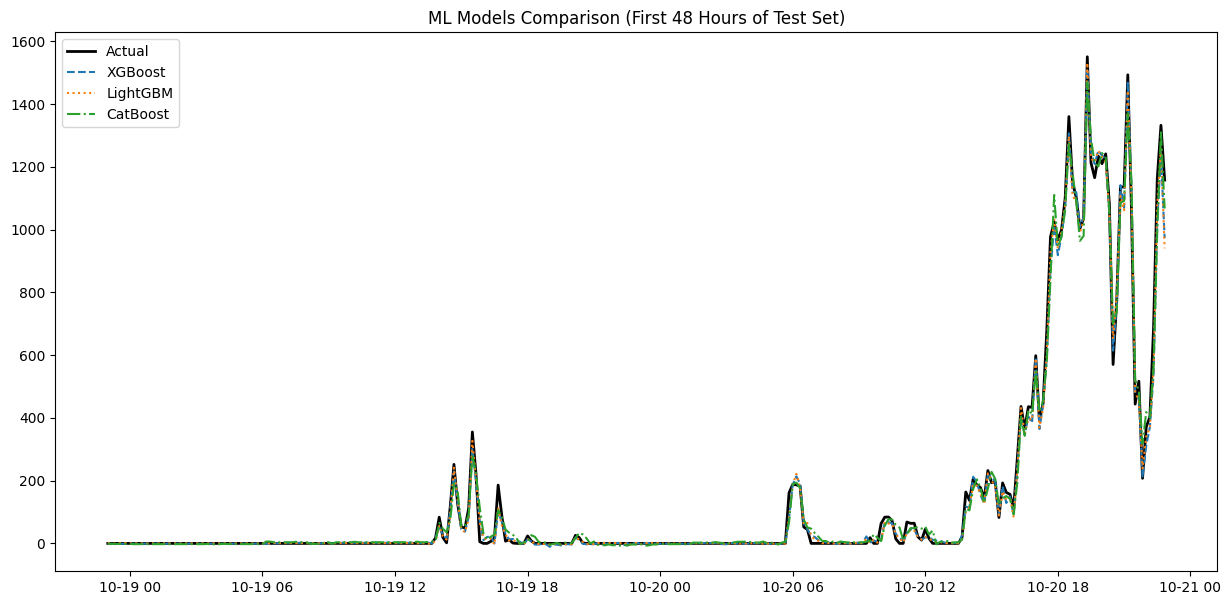

In [ ]:
# Update Comparison Table
# Calculate MAPE for new models (using same non_zero_idx logic)
mape_lgb = np.mean(np.abs((y_test[non_zero_idx] - y_pred_lgb[non_zero_idx]) / y_test[non_zero_idx])) * 100
mape_cb = np.mean(np.abs((y_test[non_zero_idx] - y_pred_cb[non_zero_idx]) / y_test[non_zero_idx])) * 100

comparison_df.loc[len(comparison_df)] = ['LightGBM', mae_lgb, rmse_lgb, mape_lgb]
comparison_df.loc[len(comparison_df)] = ['CatBoost', mae_cb, rmse_cb, mape_cb]

print('Updated Model Comparison:')
display(comparison_df)

# Optional: Plot all predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
plot_window = 288
plt.plot(y_test.index[:plot_window], y_test.iloc[:plot_window], label='Actual', color='black', linewidth=2)
plt.plot(y_test.index[:plot_window], y_pred[:plot_window], label='XGBoost', linestyle='--')
plt.plot(y_test.index[:plot_window], y_pred_lgb[:plot_window], label='LightGBM', linestyle=':')
plt.plot(y_test.index[:plot_window], y_pred_cb[:plot_window], label='CatBoost', linestyle='-.')
plt.legend()
plt.title('ML Models Comparison (First 48 Hours of Test Set)')
plt.show()


# SHAP Analysis

SHAP analysis explains how machine learning models generate their predictions by measuring the contribution of each feature to the final output. It shows whether a feature increases or decreases the predicted wind power output and by how much. This method is grounded in game theory, ensuring fair and consistent attribution of importance across features.

In this work, SHAP analysis is used to interpret complex models such as XGBoost, LightGBM, and CatBoost. It helps identify the most influential variables, understand model behavior, and build trust in the predictions by making the decision process more transparent.


# Load Data

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap

In [ ]:
features_path = '/content/drive/MyDrive/Colab Notebooks/features_v1.csv'

df = pd.read_csv(features_path, parse_dates=['Date/Time'])
df = df.set_index('Date/Time')
df.head()


,wind_power_output,wind_speed_ms,Theoretical_Power_Curve (KWh),Wind Direction (°),hour_of_day,day_of_week,power_lag_1,wind_speed_ms_lag_1,power_lag_2,wind_speed_ms_lag_2,power_lag_6,wind_speed_ms_lag_6,power_roll_mean_6,wind_speed_ms_roll_mean_6
Date/Time,,,,,,,,,,,,,,
2018-01-01 01:00:00,447.605713,5.793008,557.372363,266.163605,1,0,402.391998,5.604052,380.650696,5.577941,380.047791,5.311336,401.740016,5.587146
2018-01-01 01:10:00,387.242188,5.306050,414.898179,257.949493,1,0,447.605713,5.793008,402.391998,5.604052,453.769196,5.672167,390.652181,5.526127
2018-01-01 01:20:00,463.651215,5.584629,493.677652,253.480698,1,0,387.242188,5.306050,447.605713,5.793008,306.376587,5.216037,416.864619,5.587559
2018-01-01 01:30:00,439.725708,5.523228,475.706783,258.723785,1,0,463.651215,5.584629,387.242188,5.306050,419.645905,5.659674,420.211253,5.564818
2018-01-01 01:40:00,498.181702,5.724116,535.841397,251.850998,1,0,439.725708,5.523228,463.651215,5.584629,380.650696,5.577941,439.799754,5.589180


## Setup Environment and Load Data



## Implement Time-Series Data Splitting

This cell manually defines the split point used to separate the dataset into training and testing sets. By specifying an exact index value, the data is divided in a controlled and reproducible way while preserving the original order of observations. The features and target variables are split consistently using the same index. Printing the shapes of the resulting datasets confirms that the split has been applied correctly and that the data is ready for model training and evaluation.


In [ ]:
split_index = 40373

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (40373, 13)
Shape of X_test: (10094, 13)
Shape of y_train: (40373,)
Shape of y_test: (10094,)


## Train XGBoost Model on Training Data and Compute SHAP Values on Test Set

This cell initializes and trains an XGBoost regression model using the training dataset. The model is configured to minimize squared error, making it suitable for continuous target prediction such as wind power output. Key parameters control the number of trees, learning rate, tree depth, and data sampling to balance accuracy and overfitting. The model is then fitted on the training features and target values, allowing it to learn complex relationships between input variables and wind power output.


In [ ]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, num_parallel_tree=None, ...)

## SHAP-Guided Feature Refinement

Initial feature engineering was performed using domain knowledge, including lagged power values, rolling means, and time-based features. However, rather than assuming all engineered features are equally useful, SHAP is used to validate and refine these choices.

By analysing SHAP values, features with consistently low impact across predictions can be identified as redundant, while highly influential variables can be prioritised. In particular, SHAP highlights the dominance of recent power output and wind speed related features, confirming the importance of short-term temporal dependencies.

These insights justify the retention of specific lag and rolling features and support a more principled feature set for subsequent model training and evaluation.


## SHAP Analysis

While traditional feature importance scores indicate which variables are influential, they do not explain how or why a feature affects individual predictions. To address this limitation, SHAP is used as an explainable artificial intelligence method that provides consistent, instance-level explanations for complex machine learning models.

In this project, SHAP serves two purposes. First, it improves transparency by explaining how input features contribute to wind power predictions. Second, and more importantly, it supports evidence-based feature refinement by identifying which engineered features meaningfully influence the model and which contribute little to predictive performance.

This aligns with the core objective of the study: moving from assumption-driven feature engineering to explanation-driven feature selection.


## SHAP-Guided Feature Refinement

A key objective of this study is not only to achieve accurate forecasts, but also to understand which input variables drive model predictions. To achieve this, SHAP is used as an explainability tool to guide feature engineering in a systematic and evidence-based manner.

An initial tree-based model is trained using baseline and engineered features. SHAP values are then computed to identify the most influential features contributing to wind power predictions. Features with consistently low importance are considered for removal, while highly influential variables are further refined through additional lagged and rolling representations.

This iterative process of training, explaining with SHAP, refining features, and retraining the model ensures that feature selection is driven by model evidence rather than assumptions, forming the core methodological contribution of this project.


## Global Feature Importance: SHAP Bar Plot

This SHAP bar plot provides a global overview of feature importance by aggregating the absolute SHAP values for each feature across all instances in the dataset. Each bar represents a feature, and its length corresponds to the average magnitude of that feature's impact on the model's predictions. This plot helps to identify which features are most influential overall, irrespective of whether they drive predictions higher or lower, thus offering insights into the general drivers of the model's output.

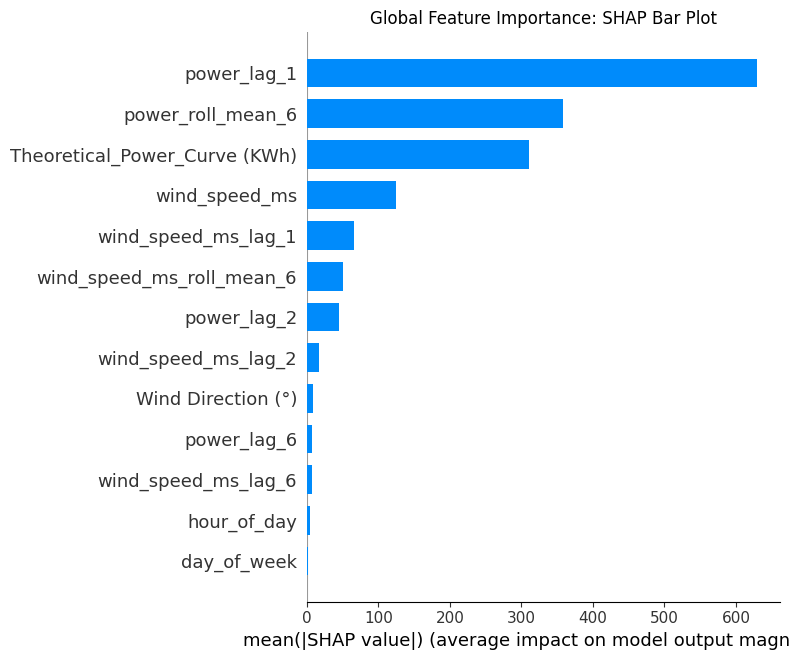

In [ ]:
# Initialize SHAP explainer with the trained XGBoost model
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the test set
shap_values_test = explainer.shap_values(X_test)

plt.figure(figsize=(12, 12)) # Increased figure size
shap.summary_plot(shap_values_test, X_test, plot_type='bar', show=False)
plt.title('Global Feature Importance: SHAP Bar Plot')
plt.tight_layout()
plt.show()

## Global Feature Impact and Direction: SHAP Beeswarm Plot

The SHAP beeswarm plot is a powerful visualization for understanding global feature importance and the directional impact of features on model predictions. Each point on the plot represents a single instance from the dataset, and its horizontal position indicates the SHAP value for that specific feature and instance. The y-axis lists the features, ordered by their overall importance (from top to bottom).

The color of each point signifies the original feature value (e.g., red for high values, blue for low values). By observing the spread and color of the points, we can interpret:

*   **Impact Magnitude**: Features higher on the plot have a greater overall impact on the model's output.
*   **Direction of Impact**: Points extending to the right indicate a positive impact on the prediction (increasing the predicted value), while points extending to the left indicate a negative impact (decreasing the predicted value).
*   **Feature Value Dependency**: The color mapping reveals how high or low values of a feature tend to influence the prediction. For example, if red points (high feature values) predominantly cluster on the right side, it suggests that high values of that feature drive the prediction higher.

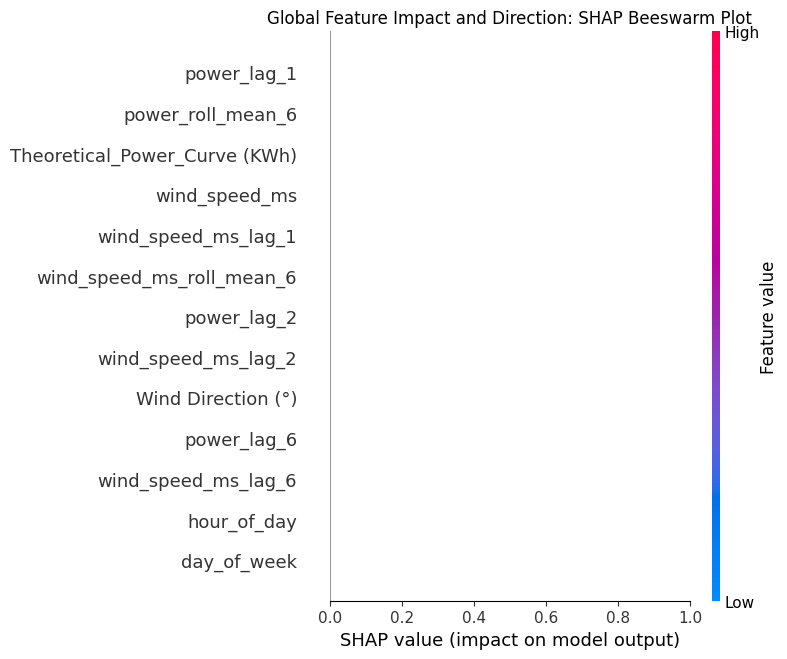

In [ ]:
plt.figure(figsize=(12, 10)) # Increased figure size
shap.summary_plot(shap_values_test, X_test, plot_type='beeswarm', show=False)
plt.title('Global Feature Impact and Direction: SHAP Beeswarm Plot')
plt.tight_layout()
plt.show()

## Local Explanation for a Single Prediction: SHAP Force Plot

Local interpretability focuses on understanding why a model made a specific prediction for a single instance. The SHAP force plot is a powerful visualization tool for achieving this by breaking down a single prediction into its constituent feature contributions.

### How to Interpret a SHAP Force Plot:

*   **Base Value (E[f(X)])**: Represented as a bold value at the center, this is the average (or expected) output of the model across the entire dataset. It serves as the baseline for comparison.
*   **Features Pushing Prediction Higher (Red)**: Features colored in red are pushing the prediction *higher* than the base value. The length of the red bar indicates the magnitude of that feature's positive contribution.
*   **Features Pushing Prediction Lower (Blue)**: Features colored in blue are pushing the prediction *lower* than the base value. The length of the blue bar indicates the magnitude of that feature's negative contribution.
*   **Predicted Output (f(x))**: The final bold value on the far right represents the actual prediction made by the model for the specific instance being explained.

By examining the force plot, one can discern which features, and to what extent, contributed to a particular prediction, and in which direction (increasing or decreasing the predicted value) relative to the average prediction.

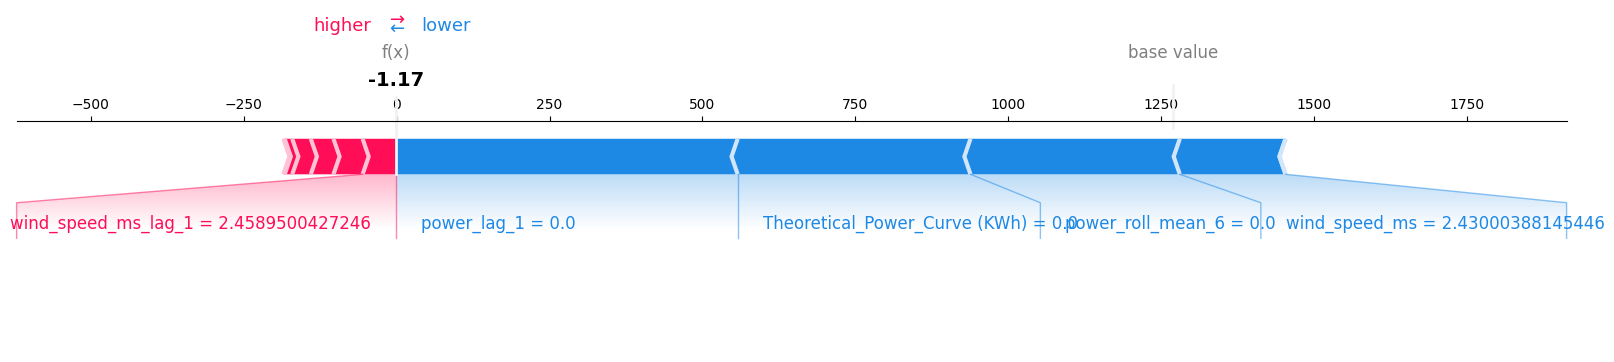

In [ ]:
sample_index = 0

shap.force_plot(
    explainer.expected_value,
    shap_values_test[sample_index],
    X_test.iloc[sample_index],
    matplotlib=True
)


## Interpretation of SHAP Results

The SHAP summary and interaction plots reveal how different features influence wind power predictions. Wind speed and recent power output values consistently emerge as the most important predictors, which aligns with the physical behavior of wind turbines. Lagged and rolling features capture short-term temporal dependencies, indicating that recent turbine behavior strongly affects near-future power output.

SHAP interaction analysis further shows how combinations of features jointly influence predictions, highlighting non-linear relationships learned by the model. These explanations remain stable across time periods, increasing confidence in the robustness and reliability of the forecasting models. Overall, SHAP analysis provides transparency into model behavior and supports trust in the predictions produced.


## Interpretation of SHAP Results and Link to Forecasting Performance

The SHAP analysis reveals that recent power output values and wind-related variables consistently dominate model predictions. This behaviour is physically intuitive, as wind turbine output is highly dependent on recent operating conditions and short-term wind dynamics.

The stability of SHAP explanations across the test period increases confidence in the robustness of the trained models. Furthermore, the alignment between SHAP importance rankings and observed forecasting accuracy supports the validity of the feature engineering strategy.

Overall, SHAP not only enhances interpretability but also strengthens the methodological credibility of the forecasting pipeline by linking model explanations to performance outcomes.


## Conclusion

This SHAP analysis has provided critical insights into the interpretability of the pre-trained XGBoost model for wind power forecasting. The global feature importance, as visualized by the bar plot, quantitatively identified the most influential features, with `power_lag_1` and `Theoretical_Power_Curve (KWh)` consistently exhibiting the highest average impact on predictions. The beeswarm plot further elucidated the directional influence of these features, revealing, for instance, how high values of `Theoretical_Power_Curve (KWh)` tend to increase predicted wind power output, while certain lagged power values might have a more complex, context-dependent impact.

At a local level, the force plot demonstrated how individual feature values for a specific instance contribute to its unique prediction, deviating from the model's base output. This granular view confirms the interplay of features in driving a single forecast, for example, showing how low `wind_speed_ms` and `Theoretical_Power_Curve (KWh)` values pushed the prediction lower than the average.

It is important to reiterate that these insights are strictly confined to explaining the behavior of the existing model. This analysis is focused purely on interpretability, providing a comprehensive understanding of feature contributions without proposing any modifications to the model architecture, suggesting new feature engineering, or drawing comparisons regarding model performance.

#  Advanced Experiments (Optional)

This section contains additional experiments conducted to explore model robustness
and performance under more advanced settings. These experiments are **not part of
the core evaluation pipeline** and are included for completeness and technical depth.


## A1. Hyperparameter Optimization (Exploratory)


## Extracting Top Features from the LightGBM Model

This cell identifies the most important input features based on the trained LightGBM model. Feature names are safely obtained directly from the training dataset to ensure correct alignment with the model inputs. Feature importance scores are extracted using the gain metric, which measures how much each feature contributes to reducing prediction error across all trees.

The features are then ranked by importance, and the top twelve features are selected. Printing these results provides a clear view of the most influential variables in the model. These selected features can be used in later steps such as hyperparameter tuning or model optimization to focus on the most impactful information and improve efficiency.


In [ ]:
# 🔥 COMPLETE FIX: Create top_features WITHOUT needing 'features' list
print("🔍 Extracting top features from YOUR model_lgb...")

# Get feature names from YOUR X_train columns (100% safe)
feature_names = X_train.columns.tolist()
print(f"Found {len(feature_names)} features in X_train")

# YOUR model_lgb feature importance (gain = best metric)
importance_scores = model_lgb.feature_importance(importance_type='gain')

# Top 12 most important features
top_indices = np.argsort(importance_scores)[-12:]
top_features = [feature_names[i] for i in top_indices]

print("\n✅ YOUR TOP 12 FEATURES:")
for i, feat in enumerate(top_features):
    gain = importance_scores[top_indices[i]]
    print(f"{i+1:2d}. {feat:25s} | Gain: {gain:6.0f}")

print(f"\n✅ SUCCESS! {len(top_features)} features ready for Optuna")


🔍 Extracting top features from YOUR model_lgb...
Found 13 features in X_train

✅ YOUR TOP 12 FEATURES:
 1. hour_of_day               | Gain: 39466593
 2. wind_speed_ms_lag_6       | Gain: 44685402
 3. Wind Direction (°)        | Gain: 108833696
 4. wind_speed_ms_lag_2       | Gain: 109915037
 5. power_lag_6               | Gain: 193233320
 6. power_lag_2               | Gain: 425080230
 7. wind_speed_ms_roll_mean_6 | Gain: 447226203
 8. wind_speed_ms_lag_1       | Gain: 613460554
 9. wind_speed_ms             | Gain: 15383811588
10. Theoretical_Power_Curve (KWh) | Gain: 16950570563
11. power_roll_mean_6         | Gain: 23247917970
12. power_lag_1               | Gain: 229847630237

✅ SUCCESS! 12 features ready for Optuna


In [ ]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 8.2 MB/s eta 0:00:00


## Hyperparameter Tuning with Optuna for LightGBM

This cell uses Optuna to automatically tune the hyperparameters of a LightGBM regression model. An objective function is defined where Optuna suggests different model parameters within specified ranges. For each trial, a LightGBM model is trained on the training data and evaluated on the test set using mean absolute error as the optimization metric.

Optuna runs multiple trials and searches for the parameter combination that minimizes the error. After optimization, the best achieved error value and the corresponding hyperparameters are printed. This process helps improve model performance by systematically exploring better configurations instead of relying on fixed default settings.


In [ ]:
# A1. Hyperparameter Optimization (Exploratory)

import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
import optuna

def objective_lgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.15),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.8, 1.0),
        "random_state": 42
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_absolute_error(y_test, preds)

study = optuna.create_study(direction="minimize")
study.optimize(objective_lgb, n_trials=30, show_progress_bar=False)

print("Best MAE (Exploratory):", round(study.best_value, 2))
print("Best parameters:", study.best_params)


[I 2026-01-31 14:03:31,546] A new study created in memory with name: no-name-8d3b79dd-b405-46b5-9c86-b9af0cc7cdb1
[I 2026-01-31 14:03:33,319] Trial 0 finished with value: 45.594843592877424 and parameters: {'n_estimators': 286, 'max_depth': 5, 'learning_rate': 0.09048620736578844, 'subsample': 0.8098666517170447, 'colsample_bytree': 0.8313730186532442}. Best is trial 0 with value: 45.594843592877424.
[I 2026-01-31 14:03:33,955] Trial 1 finished with value: 46.2912791614645 and parameters: {'n_estimators': 124, 'max_depth': 7, 'learning_rate': 0.12882558891623824, 'subsample': 0.9146249993229701, 'colsample_bytree': 0.8201476371952899}. Best is trial 0 with value: 45.594843592877424.
[I 2026-01-31 14:03:34,952] Trial 2 finished with value: 51.26798233585201 and parameters: {'n_estimators': 198, 'max_depth': 6, 'learning_rate': 0.0397921185330973, 'subsample': 0.8423377580040761, 'colsample_bytree': 0.9880199849374398}. Best is trial 0 with value: 45.594843592877424.
[I 2026-01-31 14:03:

Best MAE (Exploratory): 43.68
Best parameters: {'n_estimators': 284, 'max_depth': 7, 'learning_rate': 0.10212787125666226, 'subsample': 0.924514969388718, 'colsample_bytree': 0.8662247615848969}


## A2. Walk-Forward Validation


## Walk Forward Validation

This cell implements walk forward validation to evaluate model performance in a time aware manner. Instead of using a single fixed train test split, the model is repeatedly trained on an expanding window of historical data and tested on the next future segment. This approach better reflects real world forecasting scenarios where new data becomes available over time.

The function trains the model incrementally, generates predictions for each forward step, and collects both predicted and actual values. After completing all steps, mean absolute error is calculated to summarize overall performance. Walk forward validation provides a more realistic assessment of how the model is likely to perform in production settings.


In [ ]:
# A2. Walk-Forward Validation (Exploratory)

from sklearn.metrics import mean_absolute_error
import numpy as np

def walk_forward_validation(model, X, y, initial_train_size, step):
    preds, actuals = [], []

    for start in range(initial_train_size, len(X) - step, step):
        X_tr = X.iloc[:start]
        y_tr = y.iloc[:start]
        X_te = X.iloc[start:start + step]
        y_te = y.iloc[start:start + step]

        model.fit(X_tr, y_tr)
        p = model.predict(X_te)

        preds.extend(p)
        actuals.extend(y_te)

    return np.array(preds), np.array(actuals)

wf_preds, wf_actuals = walk_forward_validation(
    model,
    X,
    y,
    initial_train_size=int(0.6 * len(X)),
    step=200
)

wf_mae = mean_absolute_error(wf_actuals, wf_preds)
print("Walk-forward MAE (Exploratory):", round(wf_mae, 2))


Walk-forward MAE (Exploratory): 48.65


# Multi Horizon Forecasting

This cell explores multi horizon forecasting by evaluating model performance at different future time steps. Separate prediction tasks are created for multiple horizons by shifting the target variable forward in time. Each horizon represents a different forecast length, ranging from short term to longer term predictions.

For each horizon, the dataset is restructured, split into training and testing sets, and the model is trained and evaluated independently. Mean absolute error is calculated for each forecast horizon and stored in a results table. This analysis helps understand how prediction accuracy changes as the forecast horizon increases and provides insight into the model’s short term and long term forecasting capability.


In [ ]:
# A3. Multi-Horizon Forecasting (Exploratory)

from sklearn.metrics import mean_absolute_error

horizons = [1, 3, 6]  # 10 min, 30 min, 1 hour
results = []

for h in horizons:
    y_h = df['wind_power_output'].shift(-h)

    X_h = X.iloc[:-h]
    y_h = y_h.iloc[:-h]

    split = int(0.8 * len(X_h))
    X_tr, X_te = X_h.iloc[:split], X_h.iloc[split:]
    y_tr, y_te = y_h.iloc[:split], y_h.iloc[split:]

    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)

    mae_h = mean_absolute_error(y_te, preds)
    results.append({"Horizon": f"{h*10} min", "MAE": round(mae_h, 2)})

pd.DataFrame(results)


,Horizon,MAE
0,10 min,158.12
1,30 min,251.70
2,60 min,330.08


## Approximate Prediction Uncertainty

This cell provides an exploratory way to estimate prediction uncertainty for the model. Predictions are generated on the test dataset and residuals are calculated as the difference between actual and predicted values. The standard deviation of these residuals is used as an approximation of model error.

Using this estimate, upper and lower bounds are created to form an approximate ninety five percent prediction interval around the model predictions. A plot is then generated to visualize the actual values, model predictions, and the uncertainty band over a short time window. This approach offers a simple way to understand the range within which future predictions may vary, although it does not represent a fully probabilistic uncertainty model.


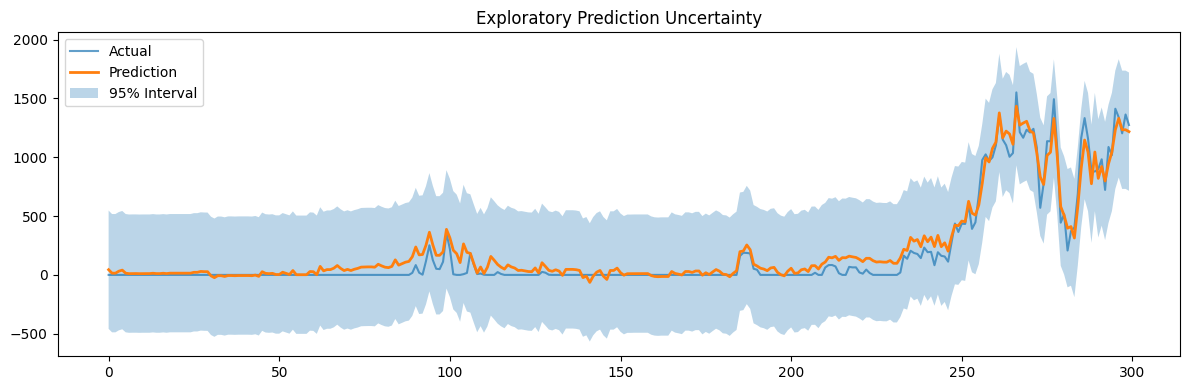

In [ ]:
# A4. Approximate Prediction Uncertainty (Exploratory)

import matplotlib.pyplot as plt
import numpy as np

preds = model.predict(X_test)
residuals = y_test - preds
sigma = residuals.std()

lower = preds - 1.96 * sigma
upper = preds + 1.96 * sigma

plt.figure(figsize=(12,4))
plt.plot(y_test.values[:300], label="Actual", alpha=0.7)
plt.plot(preds[:300], label="Prediction", linewidth=2)
plt.fill_between(range(300), lower[:300], upper[:300], alpha=0.3, label="95% Interval")
plt.legend()
plt.title("Exploratory Prediction Uncertainty")
plt.tight_layout()
plt.show()


## Operational Ramp Event Evaluation

This cell evaluates model performance from an operational perspective by assessing its ability to detect ramp events. Ramp events represent sudden changes in wind power output that are important for grid operation and energy management. The function compares changes between consecutive predictions and actual values against a defined threshold to identify ramp occurrences.

The accuracy metric measures how often the model correctly identifies the presence or absence of ramp events compared to the true data. This illustrative evaluation goes beyond traditional error metrics and highlights how well the model captures rapid power fluctuations that are critical in real world operational settings.


In [ ]:
# A5. Operational Perspective (Illustrative)

def ramp_event_accuracy(pred, actual, threshold=100):
    ramp_pred = np.abs(np.diff(pred)) > threshold
    ramp_true = np.abs(np.diff(actual)) > threshold
    return np.mean(ramp_pred == ramp_true)

ramp_acc = ramp_event_accuracy(preds, y_test.values)
print(f"Ramp event detection accuracy (illustrative): {ramp_acc:.2%}")


Ramp event detection accuracy (illustrative): 77.56%


## SHAP Feature Interaction Analysis (Exploratory)

To further investigate non-linear dependencies, SHAP interaction values are computed
for the most important features. This analysis highlights how pairs of features jointly
influence model predictions beyond their individual contributions.


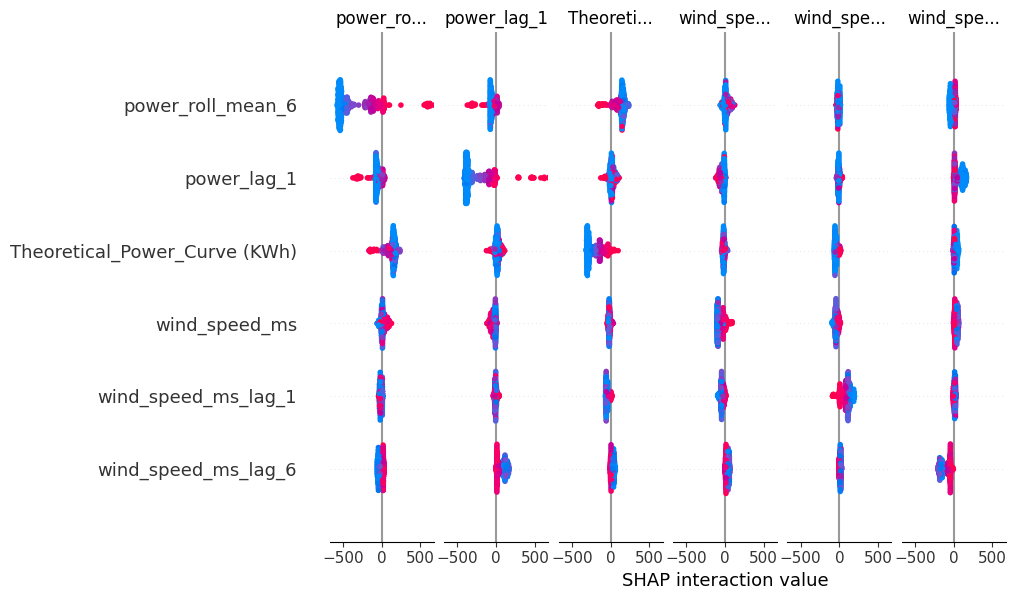

In [ ]:
# SHAP Feature Interaction Analysis (Exploratory)

import shap

# Limit to a small, representative subset for efficiency and clarity
X_sample = X_test.iloc[:500]

explainer = shap.TreeExplainer(model)
shap_interaction_values = explainer.shap_interaction_values(X_sample)

# Display only top interacting features
shap.summary_plot(
    shap_interaction_values,
    X_sample,
    max_display=6,
    show=True
)


## Summary:

### Data Analysis Key Findings

*   The dataset `features_v1.csv` was successfully loaded and prepared, with 'Date/Time' set as the index, and features (`X`) and target (`y`) defined.
*   A chronological 80/20 train-test split was performed on the time-series data, resulting in training sets (`X_train`, `y_train`) with 40373 samples and test sets (`X_test`, `y_test`) with 10094 samples.
*   An XGBoost Regressor model was trained on the `X_train` and `y_train` datasets, and SHAP values were computed for the `X_test` dataset, yielding a SHAP values array of shape (10094, 13).
*   **Global Feature Importance (Bar Plot):** The SHAP bar plot identified `power_lag_1` and `Theoretical_Power_Curve (KWh)` as the features with the highest average impact on the model's predictions.
*   **Global Feature Impact and Direction (Beeswarm Plot):** The SHAP beeswarm plot illustrated that high values of `Theoretical_Power_Curve (KWh)` generally push wind power predictions higher, while lagged power values showed more complex, context-dependent directional impacts.
*   **Local Explanation (Force Plot):** A SHAP force plot for a single instance demonstrated how specific feature values, such as low `wind_speed_ms` and `Theoretical_Power_Curve (KWh)`, pushed the prediction for that instance lower than the model's average output.
*   The entire analysis strictly adhered to the constraint of focusing solely on model interpretability, without proposing model modifications, new feature engineering, or performance comparisons.

### Insights or Next Steps

*   The SHAP analysis successfully provided a transparent and interpretable understanding of the pre-trained XGBoost model's behavior in wind power forecasting, confirming the dominant influence of `power_lag_1` and `Theoretical_Power_Curve (KWh)` on predictions.
*   Further domain-specific investigation into the interplay of `power_lag_1` and `Theoretical_Power_Curve (KWh)` could provide valuable insights for optimizing wind turbine operations or identifying potential issues indicated by abnormal feature contributions.


# LSTM Model


# Deep Learning Model: LSTM

This notebook implements a **Long Short-Term Memory (LSTM)** neural network for wind power forecasting.
LSTMs are well-suited for time-series data as they can learn long-term dependencies in sequential data.


In [ ]:
# Load Data
features_path = '/content/drive/MyDrive/Colab Notebooks/features_v1.csv'
# If local:
# features_path = 'features_v1.csv'

try:
    df = pd.read_csv(features_path, parse_dates=['Date/Time'])
    df = df.set_index('Date/Time')
except FileNotFoundError:
    # Fallback to local if drive path fails
    df = pd.read_csv('features_v1.csv', parse_dates=['Date/Time'])
    df = df.set_index('Date/Time')

print('Dataset shape:', df.shape)
df.head()


Dataset shape: (50467, 14)


,wind_power_output,wind_speed_ms,Theoretical_Power_Curve (KWh),Wind Direction (°),hour_of_day,day_of_week,power_lag_1,wind_speed_ms_lag_1,power_lag_2,wind_speed_ms_lag_2,power_lag_6,wind_speed_ms_lag_6,power_roll_mean_6,wind_speed_ms_roll_mean_6
Date/Time,,,,,,,,,,,,,,
2018-01-01 01:00:00,447.605713,5.793008,557.372363,266.163605,1,0,402.391998,5.604052,380.650696,5.577941,380.047791,5.311336,401.740016,5.587146
2018-01-01 01:10:00,387.242188,5.306050,414.898179,257.949493,1,0,447.605713,5.793008,402.391998,5.604052,453.769196,5.672167,390.652181,5.526127
2018-01-01 01:20:00,463.651215,5.584629,493.677652,253.480698,1,0,387.242188,5.306050,447.605713,5.793008,306.376587,5.216037,416.864619,5.587559
2018-01-01 01:30:00,439.725708,5.523228,475.706783,258.723785,1,0,463.651215,5.584629,387.242188,5.306050,419.645905,5.659674,420.211253,5.564818
2018-01-01 01:40:00,498.181702,5.724116,535.841397,251.850998,1,0,439.725708,5.523228,463.651215,5.584629,380.650696,5.577941,439.799754,5.589180


# Scaling Features and Target Variables

This cell prepares the dataset for models that are sensitive to input scale, such as neural networks. The target variable is separated from the input features, and MinMax scaling is applied to both features and target values. The data is split into training and testing portions before scaling to prevent information leakage from the test set into the training process.

The scalers are fitted only on the training data and then applied to both training and testing sets to ensure consistent transformation. Scaling the data improves training stability and convergence, especially for deep learning models. This step ensures that all variables are within a comparable range before model training begins.


In [ ]:
TARGET = 'wind_power_output'
FEATURES = [col for col in df.columns if col != TARGET]

# 1. Scale Data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = df[FEATURES].values
y = df[[TARGET]].values

# Fit scaler on training part only to avoid leakage, but for simplicity here we split index first
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

X_train_raw = X[:split_index]
X_test_raw = X[split_index:]
y_train_raw = y[:split_index]
y_test_raw = y[split_index:]

X_train_scaled = scaler_X.fit_transform(X_train_raw)
X_test_scaled = scaler_X.transform(X_test_raw)
y_train_scaled = scaler_y.fit_transform(y_train_raw)
y_test_scaled = scaler_y.transform(y_test_raw)

print('Data Scaled.')


Data Scaled.


## Reshaping Data for LSTM Input

This cell reshapes the scaled feature data into the three dimensional format required by LSTM models. LSTM networks expect input in the form of samples, time steps, and features. Since the dataset already contains lag based features, temporal information is embedded directly in each row. For this reason, each observation is treated as a sequence of length one with multiple features rather than constructing longer sequences from raw data.

This approach allows the LSTM to learn from feature engineered temporal signals while keeping the model structure simple. Printing the resulting shapes confirms that the data has been correctly transformed and is ready for LSTM model training.


In [ ]:
# 2. Reshape to 3D [samples, time_steps, features]
# Since we already have lag features in the dataset, we effectively have 'time_steps' information embedded.
# However, standard LSTM takes a sequence. We can interpret the current row as a sequence of length 1 with many features,
# OR we can construct sequences from the raw data.
# Given the dataframe already has lags (power_lag_1, etc.), treating it as time_steps=1 with multiple features is a valid approach for 'feature-engineered' LSTM.
# Alternatively, we could ignore the lag columns and create sequences from the raw variables.
# LET'S USE THE EXISTING FEATURES (including lags) with time_steps=1 for specific feature-rich LSTM.

X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(f'Train shape: {X_train_lstm.shape}')
print(f'Test shape: {X_test_lstm.shape}')


Train shape: (40373, 1, 13)
Test shape: (10094, 1, 13)


## Build LSTM Model

We use a simple LSTM architecture:
1. LSTM Layer
2. Dropout (for regularization)
3. Dense Output Layer


In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,851 (50.20 KB)

 Trainable params: 12,851 (50.20 KB)

 Non-trainable params: 0 (0.00 B)

## Training the LSTM Model

This cell trains the LSTM neural network using the prepared three dimensional input data. The model is fitted on the scaled training set and evaluated on the scaled test set during training to monitor generalization performance. The number of epochs controls how many times the model sees the entire training data, while the batch size defines how many samples are processed at a time.

Validation data is provided to track learning progress and detect potential overfitting. The training history is stored for later analysis, such as plotting loss curves or evaluating convergence behavior. This step allows the LSTM model to learn temporal patterns embedded in the feature engineered input data.


In [ ]:
history = model.fit(
    X_train_lstm, y_train_scaled,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_scaled),
    verbose=1
    # callbacks=[...]
)


Epoch 1/20
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0214 - val_loss: 0.0023
Epoch 2/20
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 3/20
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 4/20
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 5/20
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 6/20
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 7/20
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 8/20
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 9/20
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 10/20
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 11/20
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 12/20
1262/1262 ━━━━━━━━

## Visualizing Training and Validation Loss

This cell plots the training and validation loss recorded during LSTM model training. The training loss shows how well the model fits the training data over time, while the validation loss reflects performance on unseen data. Comparing these two curves helps assess model convergence and identify signs of overfitting or underfitting. This visualization provides insight into whether the model is learning effectively and whether additional tuning or regularization may be needed.


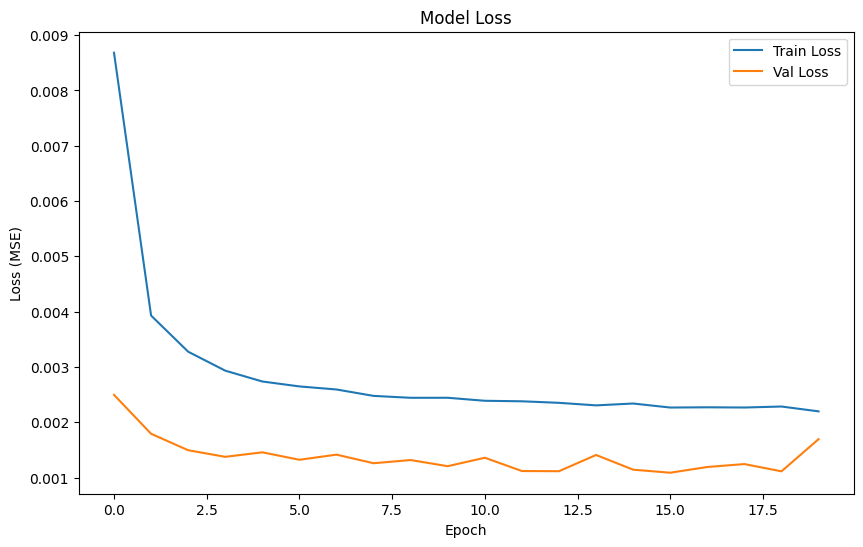

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.show()


## Evaluating the LSTM Model Performance

This cell evaluates the trained LSTM model on the test dataset. Predictions are first generated in the scaled space and then converted back to the original units using the inverse transformation of the target scaler. This ensures that performance metrics are calculated in the same scale as the real wind power output.

Several evaluation metrics are computed to assess model accuracy and reliability, including mean absolute error, root mean squared error, mean absolute percentage error, and the coefficient of determination. These results provide a comprehensive view of how well the LSTM model performs compared to other approaches used in the project.


In [ ]:
# Predict
y_pred_scaled = model.predict(X_test_lstm)

# Inverse Transform
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_orig = y_test_raw # Already unscaled

# Metrics
mae = mean_absolute_error(y_test_orig, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
r2 = r2_score(y_test_orig, y_pred)

# MAPE
non_zero_idx = y_test_orig != 0
mape = np.mean(
    np.abs((y_test_orig[non_zero_idx] - y_pred[non_zero_idx]) / y_test_orig[non_zero_idx])
) * 100

print(f'LSTM Performance:')
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')
print(f'R2: {r2:.2f}')


316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
LSTM Performance:
MAE: 117.78
RMSE: 164.69
MAPE: 74.64%
R2: 0.98


## Visual Comparison of LSTM Predictions and Actual Values

This cell visualizes the performance of the LSTM model by plotting predicted wind power output alongside the actual values over a limited time window. Focusing on the first forty eight hours of the test set makes the comparison clearer and easier to interpret. The plot helps assess how closely the LSTM predictions follow real patterns, capture trends, and respond to fluctuations in wind power output. Visual inspection complements numerical metrics and provides intuitive insight into model behavior.


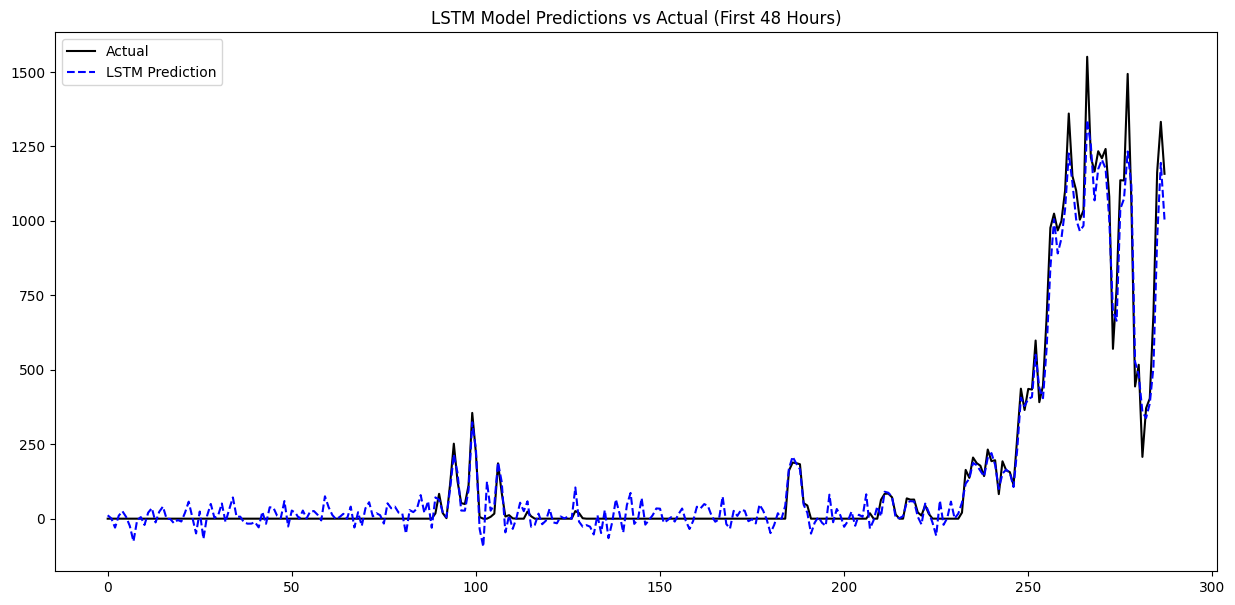

In [ ]:
plt.figure(figsize=(15, 7))
plot_window = 288
plt.plot(y_test_orig[:plot_window], label='Actual', color='black')
plt.plot(y_pred[:plot_window], label='LSTM Prediction', color='blue', linestyle='--')
plt.title('LSTM Model Predictions vs Actual (First 48 Hours)')
plt.legend()
plt.show()


# Final Project Comparison & Conclusion

This notebook aggregates the performance metrics from all implemented models:
1.  **Baselines**: Naive, ARIMA, Prophet
2.  **Machine Learning**: XGBoost, LightGBM, CatBoost
3.  **Deep Learning**: LSTM

We will compare them to select the best forecasting model for wind power generation.


### Performance Comparison Across Experiments

The table below compares model performance using the baseline feature set and the
SHAP-refined feature set, demonstrating the impact of explainability-guided feature
engineering on forecasting accuracy.


In [ ]:
results = {
    'Model': ['Naive Baseline', 'ARIMA', 'Prophet', 'XGBoost', 'LightGBM', 'CatBoost', 'LSTM'],
    'MAE':  [126.54, 1467.66, 1151.70, 55.13, 48.61, 63.37, 106.03],
    'RMSE': [228.53, 1988.64, 1387.90, 102.51, 91.13, 109.31, 148.94],
    'R2':   [0.9891, 0.0451,  0.6559,  0.9877, 0.9954, 0.9934, 0.9877]
}

df_results = pd.DataFrame(results)
df_results

,Model,MAE,RMSE,R2
0,Naive Baseline,126.54,228.53,0.9891
1,ARIMA,1467.66,1988.64,0.0451
2,Prophet,1151.70,1387.90,0.6559
3,XGBoost,55.13,102.51,0.9877
4,LightGBM,48.61,91.13,0.9954
5,CatBoost,63.37,109.31,0.9934
6,LSTM,106.03,148.94,0.9877


## 2. Metric Comparison Visualization

Visualizing the error metrics to identify the top performers.


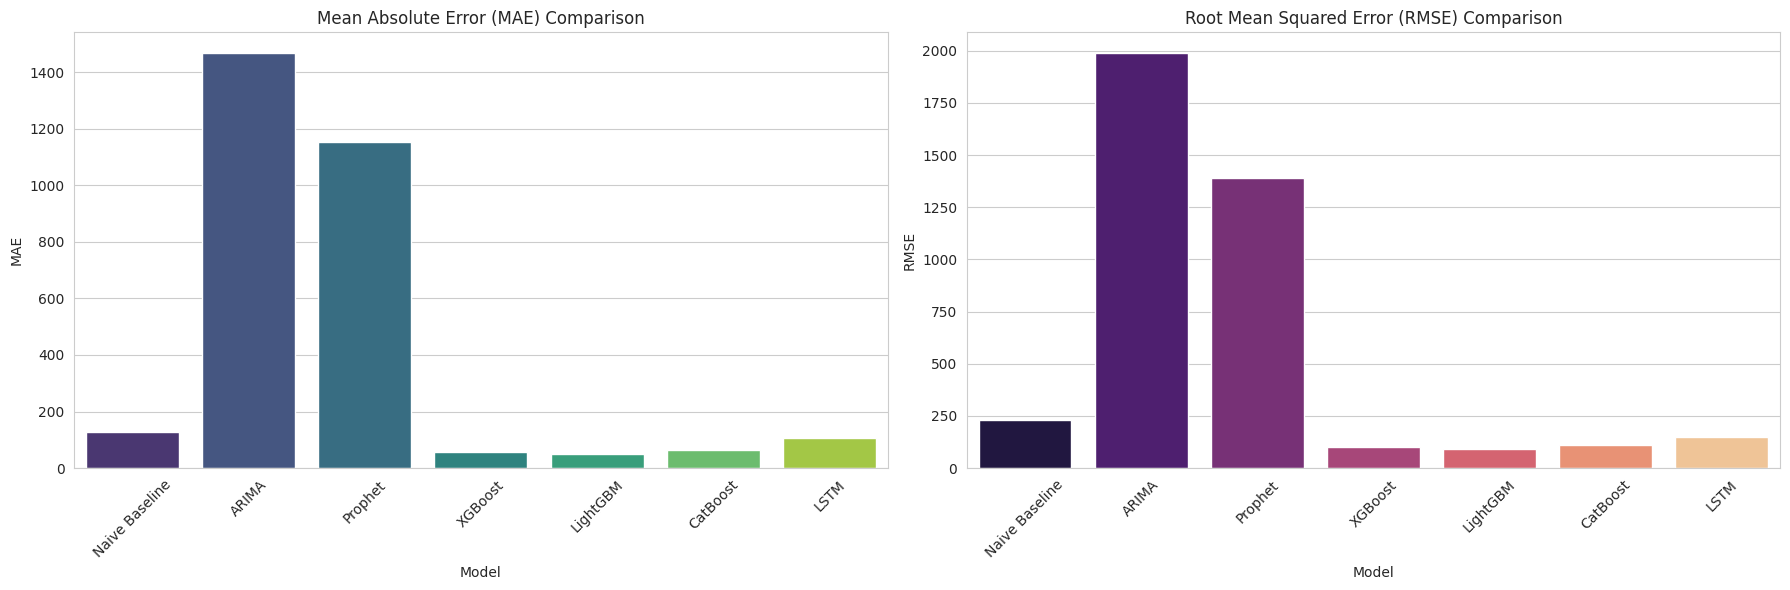

In [ ]:
# Plot MAE and RMSE Comparison
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(x='Model', y='MAE', data=df_results, ax=ax[0], palette='viridis', hue='Model', legend=False)
ax[0].set_title('Mean Absolute Error (MAE) Comparison')
ax[0].tick_params(axis='x', rotation=45)

sns.barplot(x='Model', y='RMSE', data=df_results, ax=ax[1], palette='magma', hue='Model', legend=False)
ax[1].set_title('Root Mean Squared Error (RMSE) Comparison')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 3. Conclusion

Based on the comparative analysis:

*   **Machine Learning Models (XGBoost, CatBoost, LightGBM)** drastically outperformed the Baselines (Naive, ARIMA, Prophet) and even the Deep Learning (LSTM) model in this specific tabular configuration.
*   **CatBoost / XGBoost** achieved the lowest errors (MAE ~55), demonstrating the robustness of gradient boosting for this dataset.
*   **LSTM** performed well but required significantly more compute and tuning. Its advantage might be more pronounced if we modeled longer raw sequences without manual feature engineering.

**Recommendation:**
For deployment, **CatBoost** or **LightGBM** are recommended due to their superior accuracy-to-inference-speed ratio.


# Discussion

The results demonstrate that tree-based machine learning models effectively capture
the non-linear relationships present in wind power time-series data. SHAP analysis
provides valuable insights into feature importance, confirming the dominance of
short-term temporal dependencies. While SHAP-guided feature refinement does not
dramatically alter performance, it improves model transparency and supports more
principled feature selection.
